## Evaluate WoFSCast Performance 

In [1]:
## From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast.model import WoFSCastModel
from plot_params import target_vars, display_name_mapper, units_mapper

from wofscast.data_generator import (load_chunk, 
                                     WRFZarrFileProcessor,
                                     WoFSDataProcessor, 
                                     dataset_to_input,
                                     add_local_solar_time
                                    )
# Third-party
import os 
import xarray 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import pickle, joblib
import pandas as pd
import time
from scipy import stats
from itertools import product
from scipy.fft import dct
from scipy.ndimage import uniform_filter
from scipy.signal import convolve

import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')
import monte_python
from skimage.measure import regionprops
from wofscast.plot import WoFSColors, WoFSLevels


CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]


def mean_preserving_time(x: xarray.DataArray) -> xarray.DataArray:
    return x.mean([d for d in x.dims if d != 'time'], skipna=True)

def _border_mask(shape, N=10):
    """
    Create a border mask for an array of given shape.

    Parameters:
    - shape: tuple, the shape of the array (NY, NX).
    - N: int, the width of the border where values should be True.

    Returns:
    - mask: jax.numpy.ndarray, a mask where border values are True and interior values are False.
    """
    NY, NX = shape
    mask = np.zeros(shape, dtype=bool)

    # Set the border to True
    mask[:N, :] = True  # Top border
    mask[-N:, :] = True  # Bottom border
    mask[:, :N] = True  # Left border
    mask[:, -N:] = True  # Right border

    return mask

# Create a border mask for the domain (slow to constantly recreate this!!!)
BORDER_MASK = _border_mask((150, 150), N=3)  # Adjust N as needed

# Function to calculate RMSE while ignoring the borders
def rmse_ignoring_borders(predictions, targets):
    # Set the errors at the borders to NaN
    err = (predictions - targets)**2
    err = xarray.where(BORDER_MASK, np.nan, err)  # Apply the border mask
    
    # Compute mean squared error while preserving 'time' dimension
    mse = mean_preserving_time(err)
    
    # Calculate the RMSE
    rmse = np.sqrt(mse)
    return rmse


def rmse_in_convection(predictions, targets, refl_mask):
    
    # Set the errors at the borders to NaN
    err = (predictions - targets)**2
    err = xarray.where(refl_mask, err, np.nan)  # Apply the refl mask
    
    # Compute mean squared error while preserving 'time' dimension
    mse = mean_preserving_time(err)
    
    # Calculate the RMSE
    rmse = np.sqrt(mse)
    return rmse


In [3]:
def accumulate_rmse(targets, predictions, target_vars, rmse_dict):
    """Accumulate RMSE for each prediction"""
    for var in target_vars: 
        # Compute full domain RMSE
        rmse = rmse_ignoring_borders(predictions[var], targets[var])
    
        # Compute RMSE where comp. refl > 3: 
        pred_refl_mask = np.where(predictions['COMPOSITE_REFL_10CM']>3, True, False)
        tar_refl_mask = np.where(targets['COMPOSITE_REFL_10CM']>3, True, False)
    
        # Combine the masks with logical OR to create the composite reflectivity mask
        refl_mask = np.logical_or(pred_refl_mask, tar_refl_mask)
        
        # Adjust mask dimensions if necessary
        if len(refl_mask.shape) < len(predictions[var].shape):
            refl_mask = np.expand_dims(refl_mask, axis=2)
        
        refl_mask = np.broadcast_to(refl_mask, predictions[var].shape)
    
        rmse_conv = rmse_in_convection(predictions[var], targets[var], refl_mask)
    
        rmse_dict['full'][var] += rmse
        rmse_dict['partial'][var] += rmse_conv
        
    return rmse_dict

In [4]:
def process_time_step(this_pred, this_tar):
    # Identify objects
    labels_pred, pred_object_props = monte_python.label(
        input_data=this_pred['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    labels_tar, tar_object_props = monte_python.label(
        input_data=this_tar['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    # Quality control
    labels_pred, pred_object_props = qcer.quality_control(
        this_pred['COMPOSITE_REFL_10CM'], labels_pred, pred_object_props, qc_params)

    labels_tar, tar_object_props = qcer.quality_control(
        this_tar['COMPOSITE_REFL_10CM'], labels_tar, tar_object_props, qc_params)

    # Update metrics
    obj_verifier.update_metrics(labels_tar, labels_pred)
    results = {key: getattr(obj_verifier, f"{key}_") for key in ["hits", "false_alarms", "misses"]}
    
    obj_verifier.reset_metrics()
    
    return results

def replace_zeros(data): 
    return np.where(data==0, 1e-5, data)


In [5]:
matcher = monte_python.ObjectMatcher(cent_dist_max = 7, 
                                     min_dist_max = 7, 
                                     time_max=0, 
                                     score_thresh=0.2, 
                                     one_to_one = True)

obj_verifier = monte_python.ObjectVerifier(matcher)
qcer = monte_python.QualityControler()
qc_params = [('min_area', 12)]

In [6]:
def calc_FSS(pred, true, window, thres):

    binary_pred = (pred >= thres).astype(float)
    binary_true = (true >= thres).astype(float)
    
    NP_pred = uniform_filter(binary_pred, window, mode='constant')
    NP_true = uniform_filter(binary_true, window, mode='constant')

    numer = ((NP_pred - NP_true)**2).sum()
    denom = (NP_pred**2 + NP_true**2).sum()
    
    return numer, denom

In [7]:
def gen_objects(this_pred, this_tar):
    # Identify objects
    labels_pred, pred_object_props = monte_python.label(
        input_data=this_pred['COMPOSITE_REFL_10CM'].values,
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    labels_tar, tar_object_props = monte_python.label(
        input_data=this_tar['COMPOSITE_REFL_10CM'].values,
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    # Quality control
    labels_pred, pred_object_props = qcer.quality_control(
        this_pred['COMPOSITE_REFL_10CM'].values, labels_pred, pred_object_props, qc_params)

    labels_tar, tar_object_props = qcer.quality_control(
        this_tar['COMPOSITE_REFL_10CM'].values, labels_tar, tar_object_props, qc_params)

    matched_pred_labels_list, matched_true_labels_list, cent_dists = matcher.match(labels_pred, labels_tar)
    matched_pred_labels = np.where(np.isin(labels_pred, matched_pred_labels_list), labels_pred, 0)
    matched_true_labels = np.where(np.isin(labels_tar, matched_true_labels_list), labels_tar, 0)
    
    matched_pred_object_props = regionprops( matched_pred_labels, this_pred['COMPOSITE_REFL_10CM'].values,  )
    matched_true_object_props = regionprops( matched_true_labels, this_tar['COMPOSITE_REFL_10CM'].values,  )

    
    return matched_pred_object_props, matched_true_object_props

In [8]:
def calc_PMM(data):
        
    field_mean = np.mean(data, axis=2)
        
    rank_indices = np.argsort(np.ravel(field_mean))
        
    sorted_per_mem = np.zeros((data.shape[0]*data.shape[1], data.shape[2]))
    for k in range(data.shape[2]):
        sorted_per_mem[:,k] = np.sort(np.ravel(data[:,:,k]))
    sorted_1D = np.mean(sorted_per_mem, axis=1)
        
    PMM_1D = np.zeros(np.ravel(field_mean).shape)
    for count, inds in enumerate(rank_indices):
        PMM_1D[inds] = sorted_1D[count]
            
    PMM = np.reshape(PMM_1D, field_mean.shape)
            
    return PMM

def get_colormap_and_levels(var):
        if var == 'COMPOSITE_REFL_10CM':
            cmap = WoFSColors.nws_dz_cmap
            levels = WoFSLevels.dz_levels_nws
        elif var == 'RAIN_AMOUNT':
            cmap = WoFSColors.rain_cmap
            levels = WoFSLevels.rain_rate_levels
        elif var == 'UP_HELI_MAX':
            cmap = WoFSColors.wz_cmap_extend
            levels = WoFSLevels.uh_2to5_levels_3000m
        elif var == 'T2':
            cmap = WoFSColors.temp_cmap
            levels = np.arange(40., 90., 2.5)
        elif var == 'QVAPOR': 
            cmap = WoFSColors.temp_cmap
        elif var in ['W', 'WMAX']: 
            cmap = WoFSColors.wz_cmap_extend
            levels = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]#, 25]#, 30, 35, 40]
        else:
            cmap = WoFSColors.wz_cmap_extend
        
        return cmap, levels
    
def units_convert(data, var):
    
    if var=='RAIN_AMOUNT':
        data /= 25.4
    elif var=='T2':
        data = 9.0 / 5.0 * (data - 273.15) + 32.0
        
    return data

In [9]:
def process_spectra_time_step(data):
    
    data = data.squeeze()

    if len(data.dims) == 3:
        data = data.isel(level=5)
        
    if len(data.dims) != 2:
        print ('ndim should be 2, but got %d!' % data.ndim)
        return 
    
    spectrum = {}
    
    for var in spectra_vars:
        kvals, PSbins, waven = get_spectra2D_DCT(data[var])
        spectrum[var] = PSbins
    return spectrum, kvals, waven

def get_spectra2D_DCT(data, dx=3., dy=3., varray = None):
    """
    Code based on Nate Snook's implementation of the algorithm in Surcel et al. (2014)

    Arguments:
        `field` is a 2D numpy array for which you would like to find the spectrum
        `dx` and `dy` are the distances between grid points in the x and y directions in meters

    Returns a tuple of (length_scale, spectrum), where `length_scale` is the length scale in meters, and `spectrum` is 
        the power at each length scale.
    """
    _dct_type = 2
    
    u = data
    
    if type(varray) != type(None):
        v = varray
            
    # compute spectra
    
    ny, nx = u.shape

    if type(varray) == type(None):
        
        variance = 0.5*dct(dct(u, axis=0, type=_dct_type, norm='ortho'), axis=1, type=_dct_type, norm='ortho')**2
        
    else:
        
        variance = 0.5*(dct(dct(u, axis=0, type=_dct_type, norm='ortho'), axis=1, type=_dct_type, norm='ortho')**2 \
                       +dct(dct(v, axis=0, type=_dct_type, norm='ortho'), axis=1, type=_dct_type, norm='ortho')**2)
           
    kfreq   = np.fft.fftfreq(nx) * nx
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    knrm   = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm2  = 0.5*(knrm[1:,:] + knrm[:-1,:])
    knrm   = 0.5*(knrm2[:,1:] + knrm2[:,:-1])
    knrm   = knrm[:ny//2,:nx//2].flatten()
    
    # In order to make this similar to the DFT, you need to shift variances
    
    variance2 = np.zeros((ny,nx//2))
    variance3 = np.zeros((ny//2,nx//2))
    
    for i in np.arange(1,nx//2):   
        variance2[:,i-1] = variance[:,2*i-1] + variance[:,2*i]

    for j in np.arange(1,ny//2):   
        variance3[j-1,:] = variance2[2*j-1,:] + variance2[2*j,:]

    variance = variance3.flatten()
    
    kbins = np.arange(0.5, nx//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    PSbins, _, _ = stats.binned_statistic(knrm, variance, statistic = "mean", bins = kbins)
    
    PSbins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    waven = 2.*kvals / nx
            
    return kvals, PSbins, waven


In [10]:
def calc_SSIM(pred, true, var, window=27, sigma=1.0, L=100.0):

    
    SSIM_thres = {'COMPOSITE_REFL_10CM': 5, 'RAIN_AMOUNT': 1, 'T2': -999}
    
    kernel = gaussian_kernel(window, sigma)
    mu1 = convolve(pred, kernel, mode='same')
    mu2 = convolve(true, kernel, mode='same')

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = convolve(pred ** 2, kernel, mode='same') - mu1_sq
    sigma2_sq = convolve(true ** 2, kernel, mode='same') - mu2_sq
    sigma12 = convolve(pred * true, kernel, mode='same') - mu1_mu2

    C1 = (0.01*L) ** 2
    C2 = (0.03*L) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_map = np.where(((mu1 > SSIM_thres[var]) | (mu2 > SSIM_thres[var])), ssim_map, np.nan)
    SSIM = np.nanmean(ssim_map)
    #SSIM = ssim(pred, true, data_range=100)#np.nanmean(np.clip(ssim_map, -1000, 1000))
    return SSIM

def gaussian_kernel(window_size, sigma):
    ax = np.arange(-window_size // 2 + 1., window_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)

def calc_TV(image):

    grad_x = np.diff(image, axis=0)
    grad_y = np.diff(image, axis=1)
    
    TV = np.sum(np.abs(grad_x))+np.sum(np.abs(grad_y))
   
    return TV

In [11]:
%%time
# For the time series
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz'
MODEL_PATH = '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz'
#MODEL_PATH = '/work/cpotvin/WOFSCAST/model/wofscast_10min_model_noise_v1.npz'

compute_verif = False #True

N_SAMPLES = 100
n_times = 12 

FSS_vars = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT']
FSS_thres = {'COMPOSITE_REFL_10CM': 40, 'RAIN_AMOUNT': 25.4/2}
window_list = [7, 15, 27]

t = 11
DOMAIN_SIZE = 150
PATCH_SIZE = 30
buff = 5
field_list = ['COMPOSITE_REFL_10CM', 'T2', 'RAIN_AMOUNT', 'WMAX']
stat_funcs = [['min', np.min], ['max', np.max], ['med', np.median]]
prop_list = ['Centroid', 'Area', 'Eccentricity', 'Solidity', 'MajorAxisLength', 'MaxIntensity']

spectra_vars = ['COMPOSITE_REFL_10CM', 'T2', 'W']

SSIM_vars = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT', 'T2']
TV_vars = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT', 'T2']


rmse_dict = { 'full' : {v : np.zeros((n_times,)) for v in target_vars},
              'partial' : {v : np.zeros((n_times,)) for v in target_vars},
            }
cont_dict = {metric : np.zeros((n_times)) for metric in ['hits', 'misses', 'false_alarms']}
pred_spectra_dict = {v : {t: 0 for t in range(n_times)} for v in spectra_vars}
tar_spectra_dict = {v : {t: 0 for t in range(n_times)} for v in spectra_vars}
numer_dict = {v : {w: np.zeros((n_times,)) for w in window_list} for v in FSS_vars}
denom_dict = {v : {w: np.zeros((n_times,)) for w in window_list} for v in FSS_vars}
FSS_dict = {v : {w: np.zeros((n_times,)) for w in window_list} for v in FSS_vars}
SSIM_dict = {v : np.zeros((n_times,)) for v in SSIM_vars}
TV_dict = {v : np.zeros((n_times,)) for v in TV_vars}
all_matched_pred_object_props_dict = {}
all_matched_true_object_props_dict = {}
pred_patches = {field_name: [] for field_name in field_list}
true_patches = {field_name: [] for field_name in field_list}

FSS_dict_fname = MODEL_PATH.replace('.npz', '_FSS_N=%d.pkl' % N_SAMPLES)
rmse_dict_fname = MODEL_PATH.replace('.npz', '_rmse_N=%d.pkl' % N_SAMPLES)
cont_dict_fname = MODEL_PATH.replace('.npz', '_cont_N=%d.pkl' % N_SAMPLES)
pred_objects_fname = MODEL_PATH.replace('.npz', '_pred_objects_t=%d_N=%d.pkl' % (t, N_SAMPLES))
true_objects_fname = MODEL_PATH.replace('.npz', '_true_objects_t=%d_N=%d.pkl' % (t, N_SAMPLES))
pred_patches_fname = MODEL_PATH.replace('.npz', '_pred_patches_t=%d_N=%d.pkl' % (t, N_SAMPLES))
true_patches_fname = MODEL_PATH.replace('.npz', '_true_patches_t=%d_N=%d.pkl' % (t, N_SAMPLES))
#pred_field_stats_fname = MODEL_PATH.replace('.npz', '_pred_field_stats_t=%d_N=%d.pkl' % (t, N_SAMPLES))
#true_field_stats_fname = MODEL_PATH.replace('.npz', '_true_field_stats_t=%d_N=%d.pkl' % (t, N_SAMPLES))
spectra_dict_fname = MODEL_PATH.replace('.npz', '_spectra_N=%d.pkl' % N_SAMPLES)
SSIM_dict_fname = MODEL_PATH.replace('.npz', '_SSIM_N=%d.pkl' % N_SAMPLES)
TV_dict_fname = MODEL_PATH.replace('.npz', '_TV_N=%d.pkl' % N_SAMPLES)

def preprocess_fn(dataset):
        _path = '/work/mflora/wofs-cast-data/datasets_zarr/2021/'
        latlon_path = os.path.join(_path, 'wrfwof_2021-05-15_040000_to_2021-05-15_043000__10min__ens_mem_09.zarr')
        preprocess_fn = WoFSDataProcessor(latlon_path=latlon_path)
        
        dataset = preprocess_fn(dataset)
        
        dataset = add_local_solar_time(dataset) 
        
        # select sublevels. 
        #dataset = dataset.isel(level=WOFS_TASK_CONFIG_5MIN.pressure_levels)
        
        return dataset 

if compute_verif:

    model = WoFSCastModel()

    model.load_model(MODEL_PATH)#, use_transformer=False, k_hop=8, num_attn_heads=4)

    # Selecting a single ensemble member. 
    base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021/*_ens_mem_09.zarr'
    paths = glob(base_path)
    paths.sort()

    rs = np.random.RandomState(42)
    random_paths = rs.choice(paths, size=N_SAMPLES, replace=False)
    N = len(random_paths)
    
    all_matched_pred_object_props = []; all_matched_true_object_props = []

    for n, path in enumerate(random_paths):
        print (n, N)
        #dataset = load_chunk2([path], batch_over_time=False, gpu_batch_size=32)
        dataset = load_chunk([path], 1, preprocess_fn)
        dataset = dataset.compute() 
        inputs, targets, forcings = dataset_to_input(dataset, model.task_config, 
                                             target_lead_times=slice('10min', '120min'), 
                                             batch_over_time=False, n_target_steps=12)
        predictions = model.predict(inputs, targets, forcings)
        predictions['WMAX'] = predictions['W'].max(dim='level')
        targets['WMAX'] = targets['W'].max(dim='level')
        try:
            predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')
        except:
            predictions = predictions.transpose('batch', 'time',  'lat', 'lon')

        rmse_dict = accumulate_rmse(targets, predictions, target_vars, rmse_dict)

        results = [process_time_step(predictions.isel(time=t, batch=0), targets.isel(time=t, batch=0))
              for t in np.arange(n_times)]
    
        for t, result in enumerate(results):
            for key in cont_dict.keys():
                cont_dict[key][t] += result[key]

        for var in FSS_vars:
            for window in window_list: 
                for t in range(n_times):
                    numer, denom = calc_FSS(predictions[var].isel(time=t, batch=0), targets[var].isel(time=t, batch=0), window, FSS_thres[var])
                    numer_dict[var][window][t] += numer
                    denom_dict[var][window][t] += denom
                    
        matched_pred_object_props, matched_true_object_props = gen_objects(predictions.isel(time=t, batch=0), targets.isel(time=t, batch=0))

        all_pred_i = [int(region['Centroid'][0]) for region in matched_pred_object_props]
        all_pred_j = [int(region['Centroid'][1]) for region in matched_pred_object_props]
        all_true_i = [int(region['Centroid'][0]) for region in matched_true_object_props]
        all_true_j = [int(region['Centroid'][1]) for region in matched_true_object_props]
        
        for nn, (pred_i, pred_j, true_i, true_j) in enumerate(zip(all_pred_i, all_pred_j, all_true_i, all_true_j)):
            if min(pred_i, pred_j, true_i, true_j)-PATCH_SIZE/2 < buff or max(pred_i, pred_j, true_i, true_j)+PATCH_SIZE/2 > DOMAIN_SIZE-buff:
                continue
            for field_name in field_list:
                imin = pred_i - PATCH_SIZE//2; jmin = pred_j - PATCH_SIZE//2; imax = pred_i + PATCH_SIZE//2; jmax = pred_j + PATCH_SIZE//2
                patch = predictions[field_name].isel(time=t, batch=0)[imin:imax+1, jmin:jmax+1]
                patch = units_convert(patch, field_name)
                pred_patches[field_name].append(patch)
                imin = true_i - PATCH_SIZE//2; jmin = true_j - PATCH_SIZE//2; imax = true_i + PATCH_SIZE//2; jmax = true_j + PATCH_SIZE//2
                patch = targets[field_name].isel(time=t, batch=0)[imin:imax+1, jmin:jmax+1]
                patch = units_convert(patch, field_name)     
                true_patches[field_name].append(patch)       
                
        all_matched_pred_object_props += matched_pred_object_props
        all_matched_true_object_props += matched_true_object_props
        
        results = [[process_spectra_time_step(predictions.isel(time=t, batch=0)), process_spectra_time_step(targets.isel(time=t, batch=0))]
              for t in range(n_times)]
    
        for t, result in enumerate(results):
            for key in pred_spectra_dict.keys():
                if n==0:                       
                    pred_spectra_dict[key][t] = result[0][0][key]
                    tar_spectra_dict[key][t] = result[1][0][key]
                else:
                    pred_spectra_dict[key][t] += result[0][0][key]
                    tar_spectra_dict[key][t] += result[1][0][key]
                    
        for var in SSIM_vars:
            for t in range(n_times):
                SSIM = calc_SSIM(predictions[var].isel(time=t, batch=0), targets[var].isel(time=t, batch=0), var)
                if SSIM == SSIM:
                    SSIM_dict[var][t] += calc_SSIM(predictions[var].isel(time=t, batch=0), targets[var].isel(time=t, batch=0), var)#data_

        for var in TV_vars:
            for t in range(n_times):
                TV_dict[var][t] += calc_TV(predictions[var].isel(time=t, batch=0)) / calc_TV(targets[var].isel(time=t, batch=0))
                
    for key in rmse_dict.keys():
        for v in target_vars:
            rmse_dict[key][v]/=N

    with open(rmse_dict_fname, 'wb') as file:
        pickle.dump(rmse_dict, file)
    with open(cont_dict_fname, 'wb') as file:
        pickle.dump(cont_dict, file)
        
    for var in FSS_vars:
        for window in window_list: 
            for t in range(n_times):
                se = numer_dict[var][window][t] 
                potential_se = denom_dict[var][window][t]
                FSS_dict[var][window][t] = 1 - se / potential_se
                
    with open(FSS_dict_fname, 'wb') as file:
        pickle.dump(FSS_dict, file)
    
    for prop_name in prop_list:
        all_matched_pred_object_props_dict[prop_name] = [region[prop_name] for region in all_matched_pred_object_props]
        all_matched_true_object_props_dict[prop_name] = [region[prop_name] for region in all_matched_true_object_props]

    with open(pred_objects_fname, 'wb') as file:
        joblib.dump(all_matched_pred_object_props_dict, file)
    with open(true_objects_fname, 'wb') as file:
        joblib.dump(all_matched_true_object_props_dict, file)
        
    with open(pred_patches_fname, 'wb') as file:
        joblib.dump(pred_patches, file)
    with open(true_patches_fname, 'wb') as file:
        joblib.dump(true_patches, file)
        
    kvals = result[0][1]
    waven = result[0][2]
        
    for key in pred_spectra_dict.keys():
        for t in range(n_times):
            pred_spectra_dict[key][t] /= N
            tar_spectra_dict[key][t] /= N
                
    with open(spectra_dict_fname, 'wb') as file:
        pickle.dump([pred_spectra_dict, tar_spectra_dict, kvals, waven], file)
        
                    
    for var in SSIM_vars:
        for t in range(n_times):
            SSIM_dict[var][t] /= N
                
    with open(SSIM_dict_fname, 'wb') as file:
        pickle.dump(SSIM_dict, file)
        
    for var in TV_vars:
        for t in range(n_times):
            TV_dict[var][t] /= N
                
    with open(TV_dict_fname, 'wb') as file:
        pickle.dump(TV_dict, file)
    
else:
    
    with open(rmse_dict_fname, 'rb') as file:
       rmse_dict = pickle.load(file) 
    with open(cont_dict_fname, 'rb') as file:
       cont_dict = pickle.load(file) 
    
    with open(FSS_dict_fname, 'rb') as file:
        FSS_dict = pickle.load(file) 
        
    with open(pred_objects_fname, 'rb') as file:
        all_matched_pred_object_props_dict = joblib.load(file)
    with open(true_objects_fname, 'rb') as file:
        all_matched_true_object_props_dict = joblib.load(file) 

    with open(pred_patches_fname, 'rb') as file:
        pred_patches = joblib.load(file)
    with open(true_patches_fname, 'rb') as file:
        true_patches = joblib.load(file)
        
    with open(spectra_dict_fname, 'rb') as file:
        pred_spectra_dict, tar_spectra_dict, kvals, waven = pickle.load(file) 
        
    with open(SSIM_dict_fname, 'rb') as file:
        SSIM_dict = pickle.load(file) 

    with open(TV_dict_fname, 'rb') as file:
        TV_dict = pickle.load(file) 

CPU times: user 605 ms, sys: 34.4 ms, total: 639 ms
Wall time: 1.37 s


In [12]:
all_pred_i = [int(centroid[0]) for centroid in all_matched_pred_object_props_dict['Centroid']]
all_pred_j = [int(centroid[1]) for centroid in all_matched_pred_object_props_dict['Centroid']]
all_true_i = [int(centroid[0]) for centroid in all_matched_true_object_props_dict['Centroid']]
all_true_j = [int(centroid[1]) for centroid in all_matched_true_object_props_dict['Centroid']]

pred_PMMs = {field_name: 0 for field_name in field_list}
true_PMMs = {field_name: 0 for field_name in field_list}
pred_patches_arrays = {field_name: 0 for field_name in field_list}
true_patches_arrays = {field_name: 0 for field_name in field_list}

for field_name in field_list:
    pred_patches_arrays[field_name] = np.stack(pred_patches[field_name], axis=2)
    true_patches_arrays[field_name] = np.stack(true_patches[field_name], axis=2)
    pred_PMMs[field_name] = calc_PMM(pred_patches_arrays[field_name])
    true_PMMs[field_name] = calc_PMM(true_patches_arrays[field_name])
    N = len(pred_patches[field_name])
    
pred_field_stats = {}; true_field_stats = {}

for field_name, stat_func in product(field_list, stat_funcs):
    func_name = stat_func[0]
    func = stat_func[1]
    name = func_name+'_'+field_name
    pred_field_stats[name] = func(func(pred_patches_arrays[field_name], axis=0), axis=0)
    true_field_stats[name] = func(func(true_patches_arrays[field_name], axis=0), axis=0)

In [13]:
import string

lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)

## Time Series of RMSE for the Target Variables (Full Domain : Solid, In Convection: Dashed) 

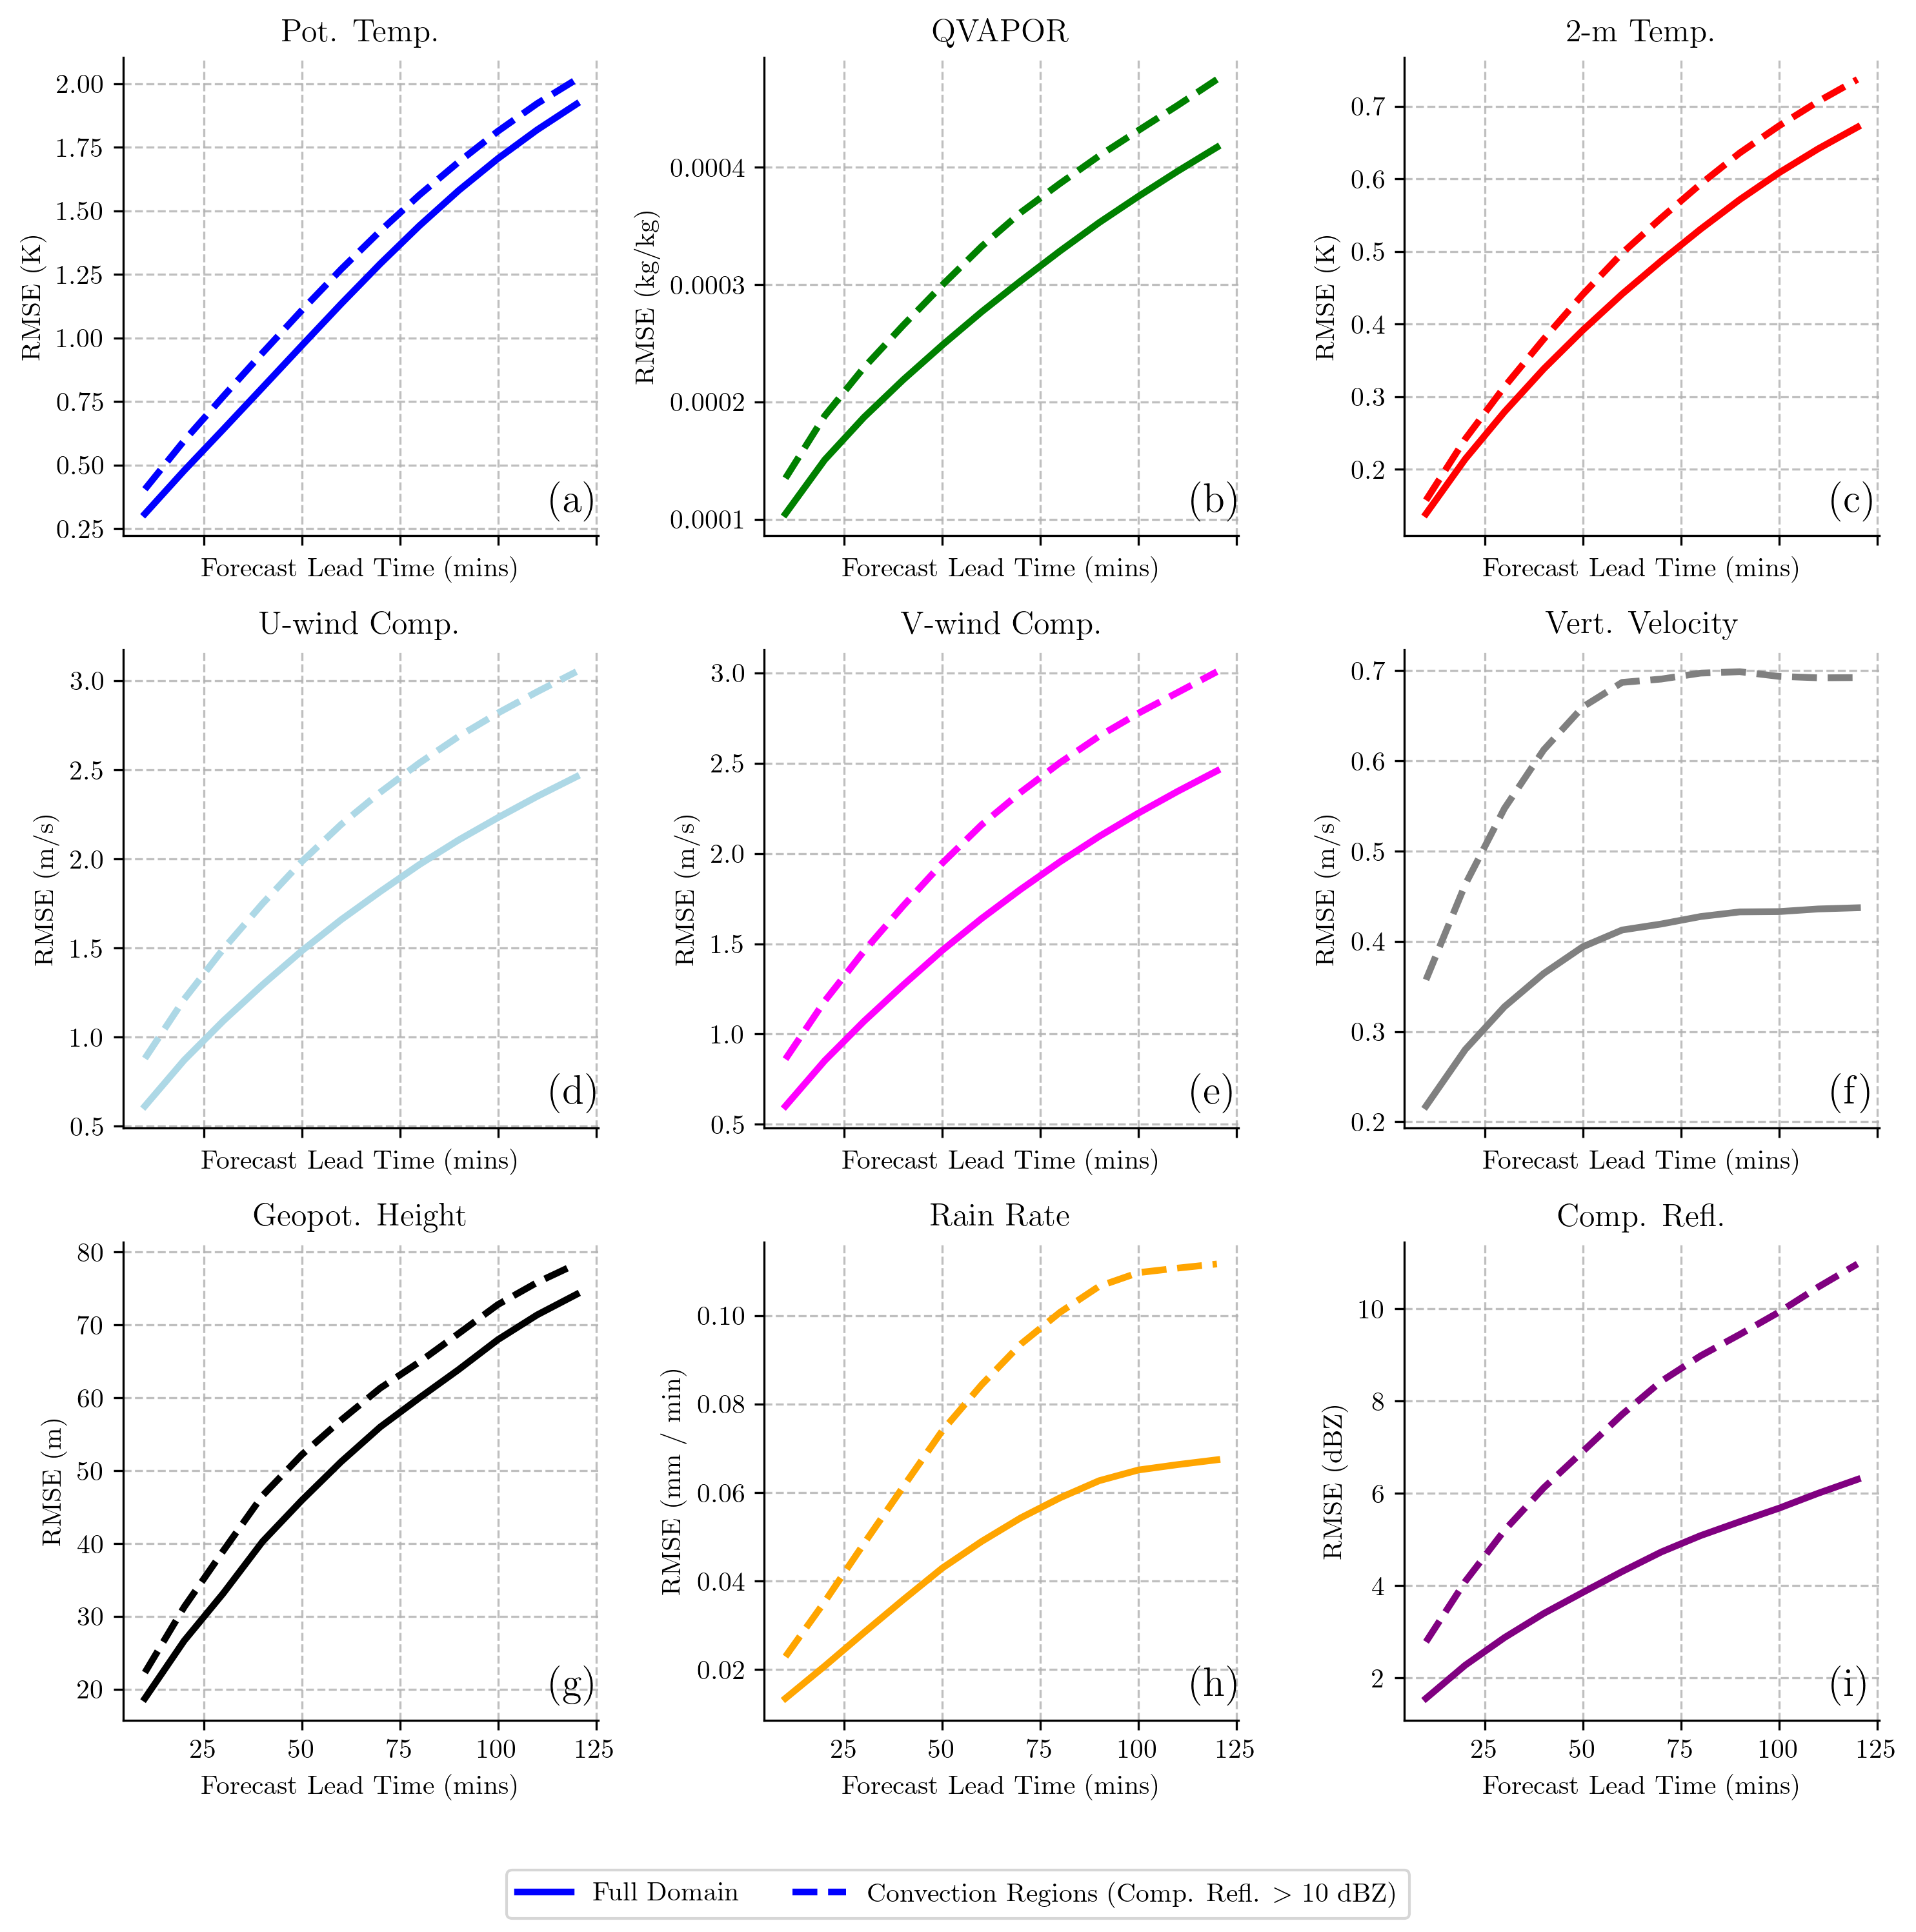

In [15]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


times = (np.arange(n_times)+1)*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']

units_mapper = {'T': 'K', 
                'QVAPOR': 'kg/kg', 
                'T2': 'K', 
                'U': 'm/s', 
                'V': 'm/s', 
                'W': 'm/s', 
                'GEOPOT': 'm', 
                'RAIN_AMOUNT': 'mm / min', 
                'COMPOSITE_REFL_10CM': 'dBZ'
               }

for i, (var, ax, c) in enumerate(zip(target_vars, axes.flat, colors)): 

    # Convert rain rate of mm / 10 min to mm/min. 
    factor = (1/10.) if var == 'RAIN_AMOUNT' else 1
    
    ax.plot(times, rmse_dict['full'][var]*factor, c=c, lw=2.5) 
    ax.plot(times, rmse_dict['partial'][var]*factor, c=c, lw=2.5, ls='dashed')

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"RMSE ({units_mapper.get(var,'')})", 
       title = display_name_mapper.get(var,var)
      )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.9, 0.05), xycoords='axes fraction', fontsize=15)
    
plt.tight_layout(rect=[0, 0.05, 1, 1])  
# Add the legend
# Note that plt.figlegend allows us to add a legend for the entire figure, using the first two plotted lines
fig.legend(loc='lower center', ncol=2, labels=[
    "Full Domain", "Convection Regions (Comp. Refl. $>$ 10 dBZ)"
])


#figname = MODEL_PATH.replace('.npz', '_RMSE.jpg')
#plt.savefig(figname, bbox_inches='tight')

## Time Series of POD, SR, CSI 

In [ ]:
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

fig, ax = plt.subplots(figsize=(9,6), dpi=300, )

cont_dict['hits'] = replace_zeros(cont_dict['hits'])
cont_dict['misses'] = replace_zeros(cont_dict['misses'])
cont_dict['false_alarms'] = replace_zeros(cont_dict['false_alarms'])

pod = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'])
sr = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['false_alarms'])
csi = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'] + cont_dict['false_alarms'])
bias = (cont_dict['hits']+cont_dict['false_alarms']) / (cont_dict['hits']+cont_dict['misses'])

ax.plot(times, pod, label='POD', c='red', ls='dashed', lw=2.5, alpha=0.9)
ax.plot(times, sr, label='SR', c='blue', lw=2.0, alpha=0.9)
ax.plot(times, csi, label='CSI', c='black', lw=2.0, alpha=0.8)
ax.plot(times, bias, label='BIAS', c='brown', lw=2.0, alpha=0.8)

ax.set_ylim(0,1)

ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS & WoFS-Cast Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.legend()
    
plt.tight_layout()
figname = MODEL_PATH.replace('.npz', '_OBJECT.jpg')
plt.savefig(figname, bbox_inches='tight')

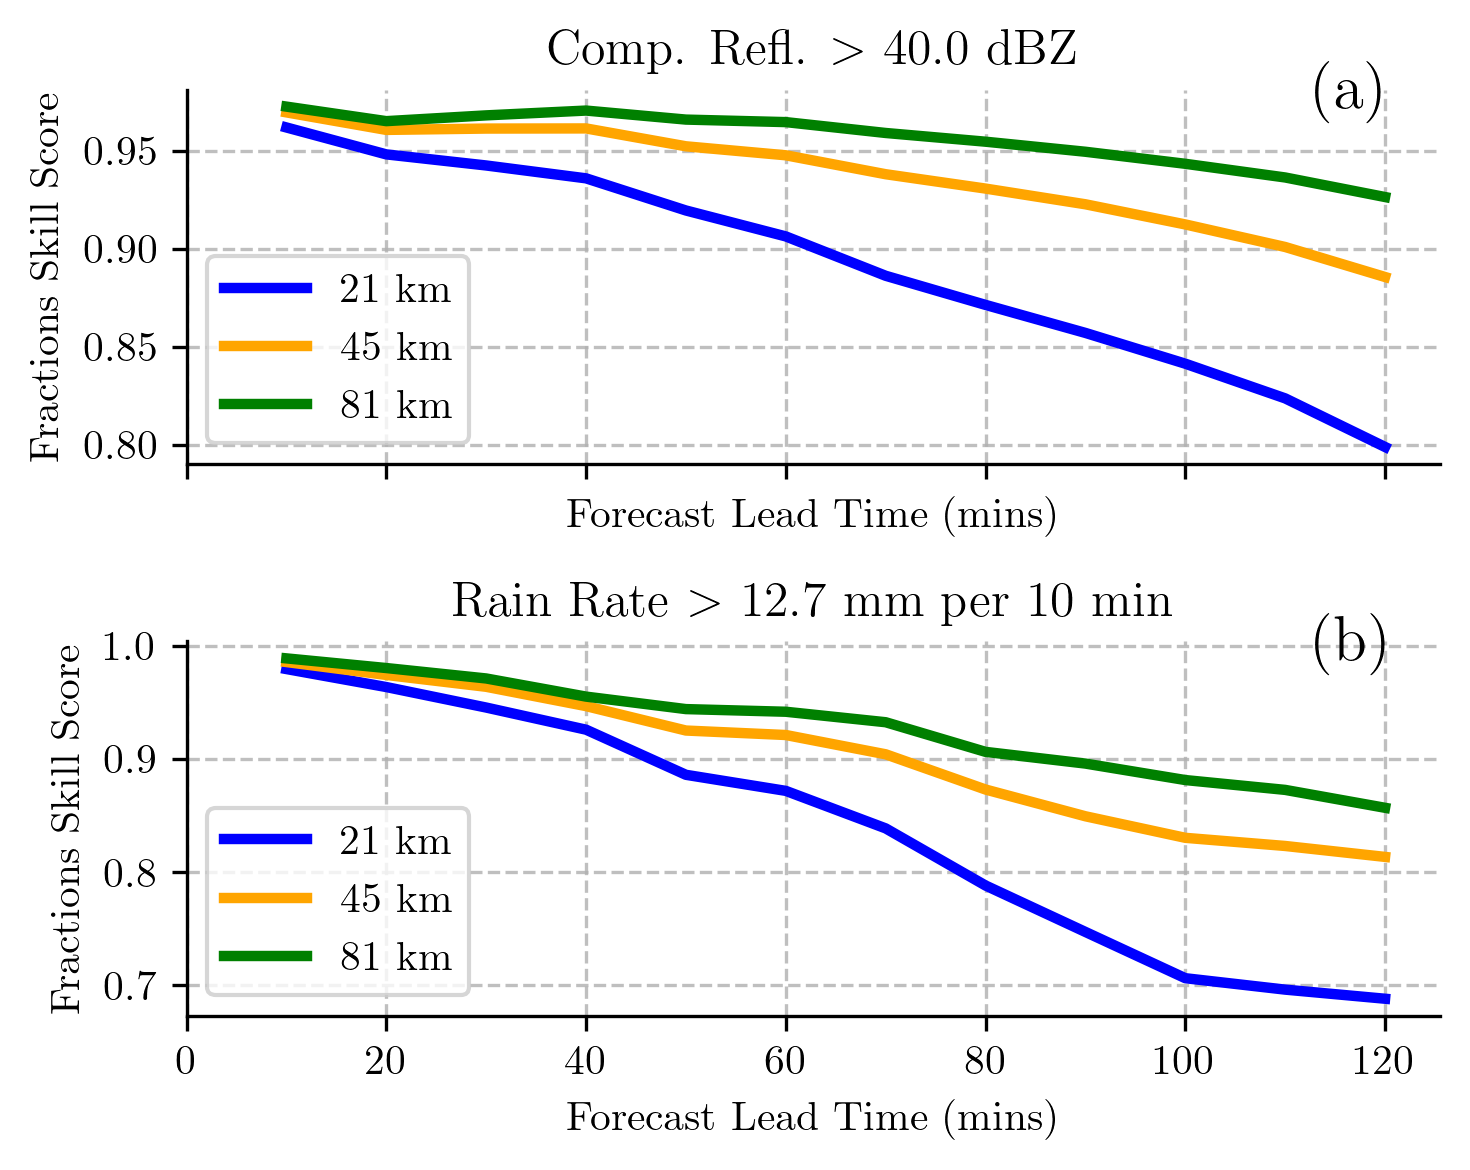

In [58]:

labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'mm per 10 min'
              }

times = (np.arange(n_times)+1)*10 # in minutes 
fig, axes = plt.subplots(figsize=(5,4), dpi=300, ncols=1, nrows=2, sharex=True)

colors = ['blue', 'orange', 'green']
fs=18
fs2=18


for i, (var, ax) in enumerate(zip(FSS_vars, axes.flat)): 
    for w, window in enumerate(window_list):
        ax.plot(times, FSS_dict[var][window], c=colors[w], lw=2.5, label='%d km' % (3*window)) 
        #ax.set_title('%s $>$ %.1f' % (labels_dict[var], FSS_thres[var]))
        
        ax.set_title(f'{labels_dict[var]} $>$ {FSS_thres[var]:.1f} {units_dict[var]}')
        
        ax.set_xlabel('Forecast Lead Time (mins)')
        ax.set_ylabel('Fractions Skill Score')

    ax.legend(loc='lower left')
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.9, 0.95), xycoords='axes fraction', fontsize=15)
    
    
plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_FSS.jpg')
#plt.savefig(figname, bbox_inches='tight')

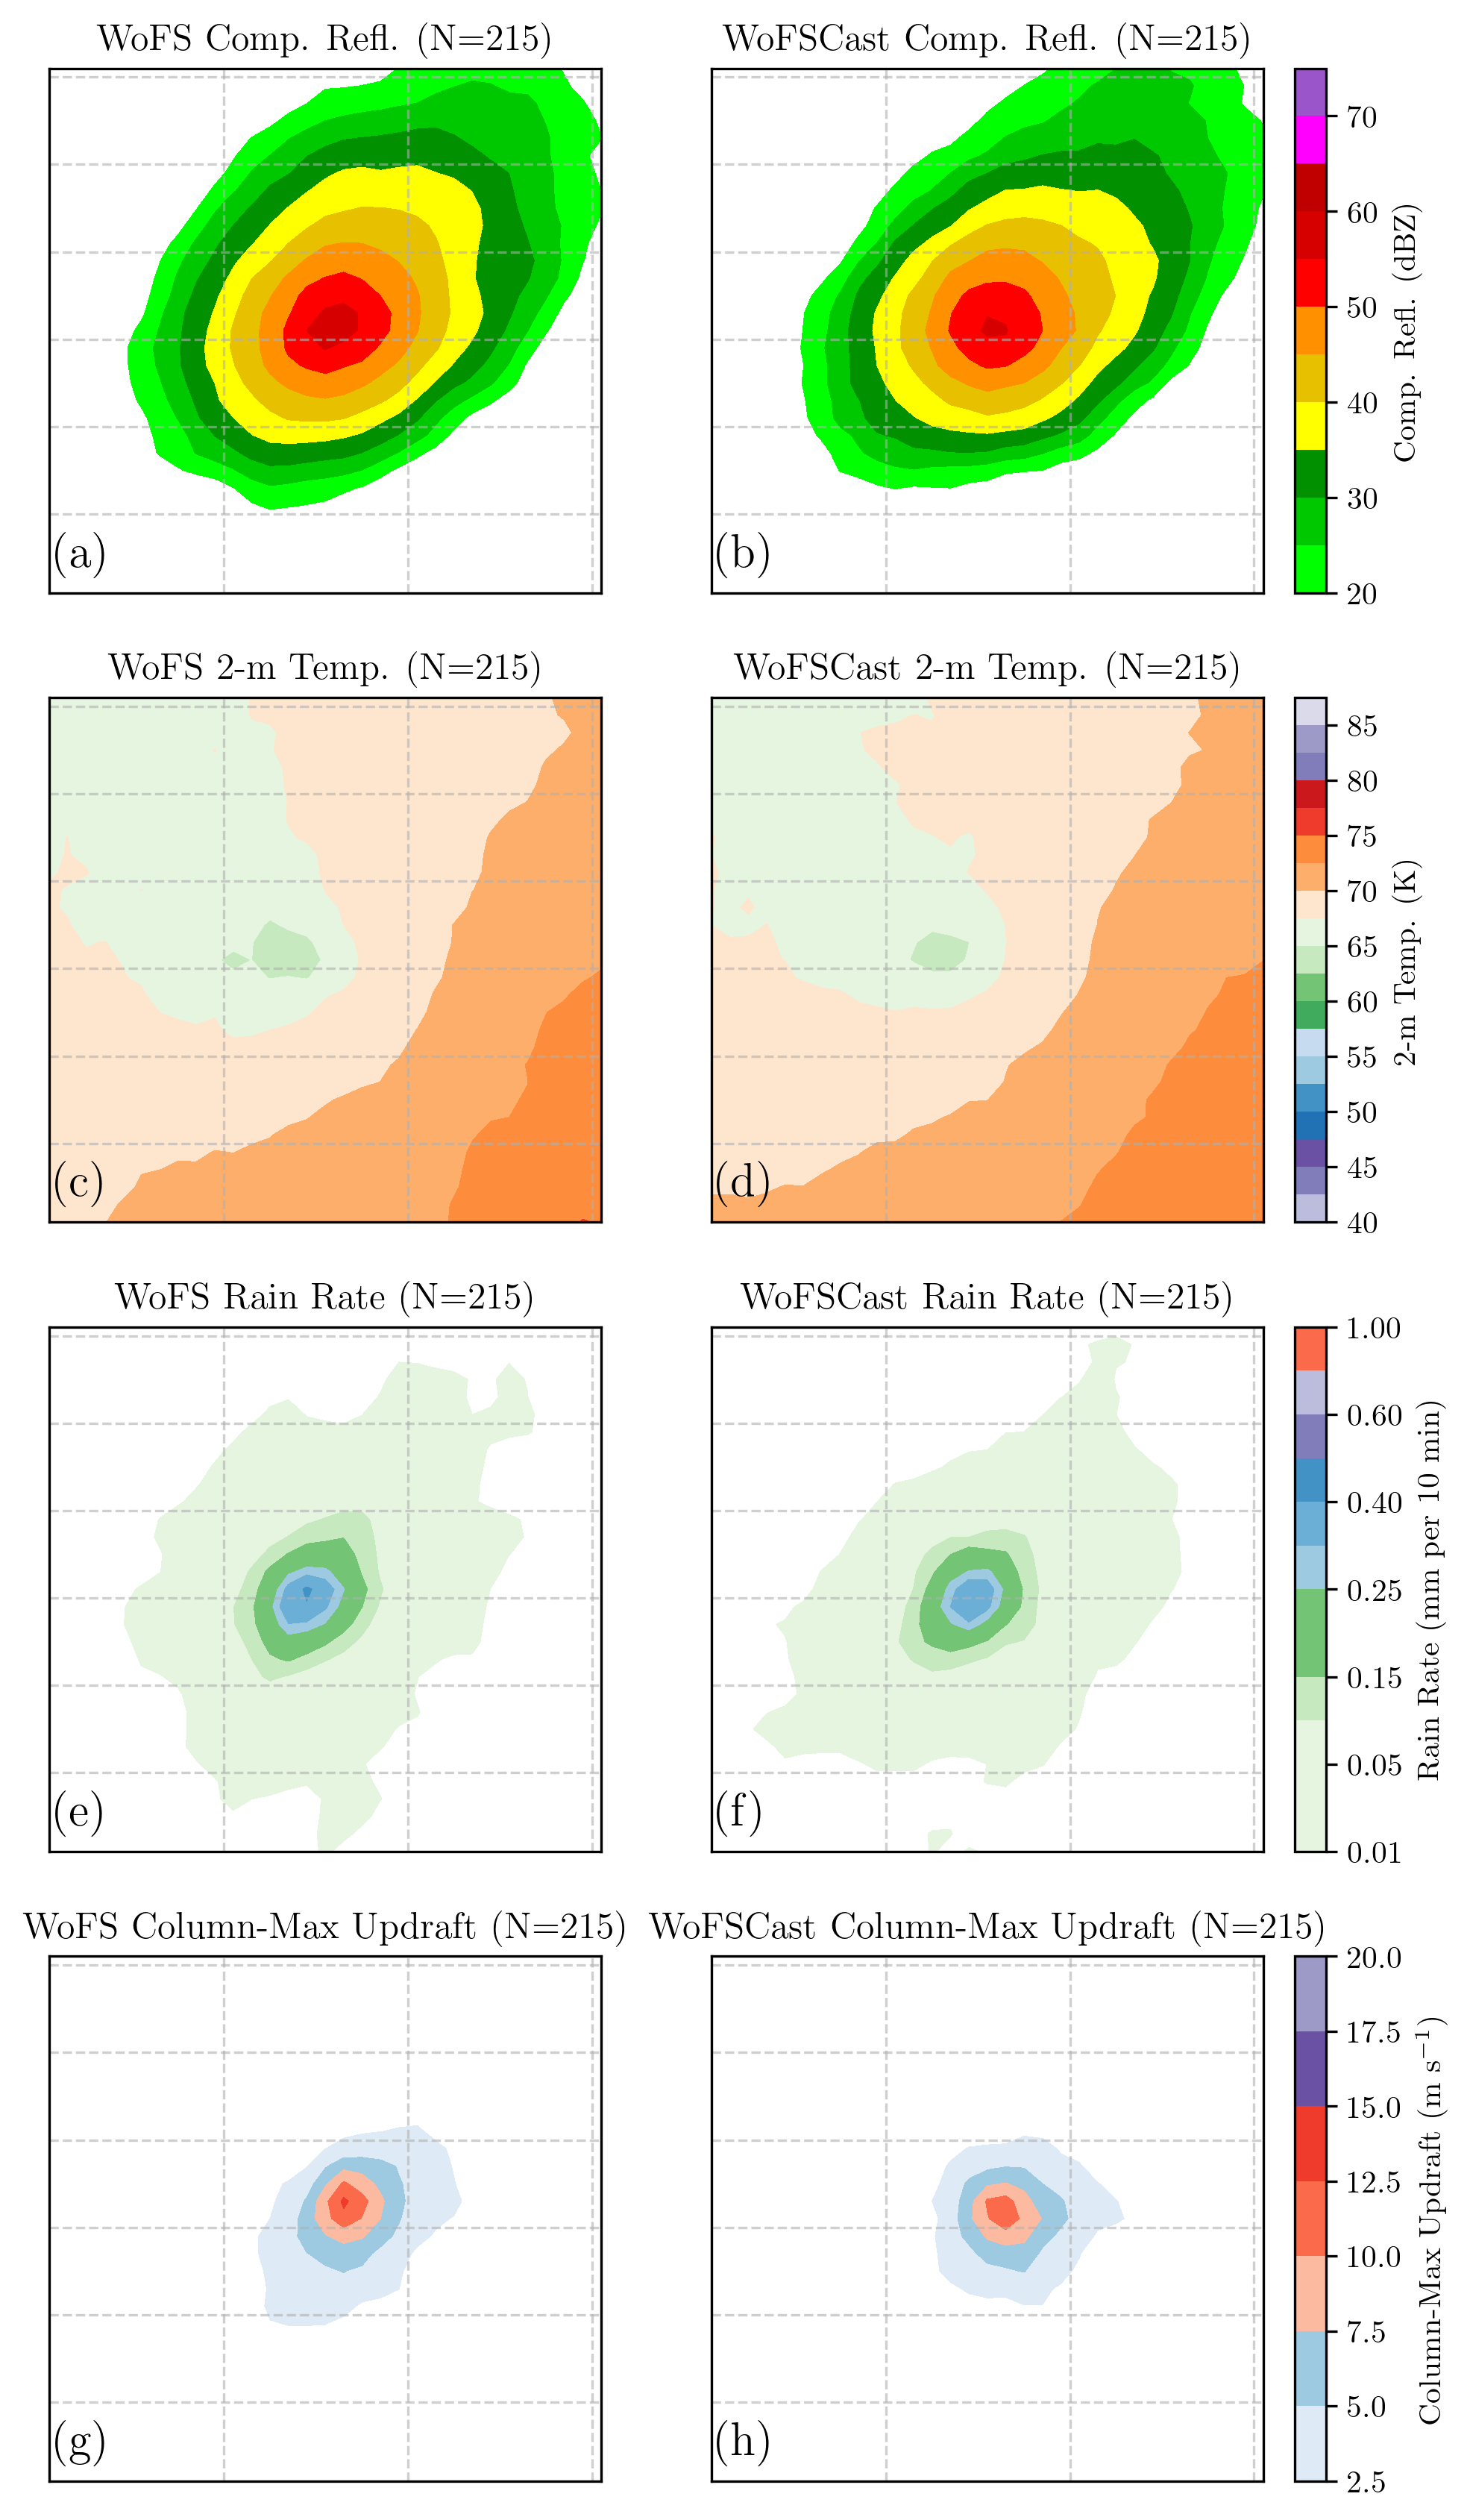

In [103]:
import matplotlib.pyplot as plt

labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate',
               'T2' : '2-m Temp.',
               'WMAX' : 'Column-Max Updraft'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'mm per 10 min',
               'T2' : 'K',
               'WMAX' : 'm s$^{-1}$'
              }


fig, axes = plt.subplots(nrows=len(field_list), ncols=2, figsize=(7, 14), dpi=300)

for i, (axs, field_name) in enumerate(zip(axes, field_list)):
    cmap, levels = get_colormap_and_levels(field_name)
    
    # Plot the first column
    im1 = axs[0].contourf(true_PMMs[field_name], origin='lower', aspect='equal', cmap=cmap, levels=levels)
    axs[0].set_title('WoFS %s (N=%d)' % (labels_dict[field_name], N), fontweight='bold')
    
    # Plot the second column
    im2 = axs[1].contourf(pred_PMMs[field_name], origin='lower', aspect='equal', cmap=cmap, levels=levels)
    axs[1].set_title('WoFSCast %s (N=%d)' % (labels_dict[field_name], N), fontweight='bold')
    

    # Create a colorbar axis on the right side of the second panel
    cbar_ax = fig.add_axes([axs[1].get_position().x1 + 0.02, 
                            axs[1].get_position().y0, 
                            0.02, 
                            axs[1].get_position().height])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_ylabel(f'{labels_dict[field_name]} ({units_dict[field_name]})')
    
    
    
for i, ax in enumerate(axes.flat):
    ax.grid(ls='dashed', alpha=0.6)
    # Turn off tick marks for both axes
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.01, 0.05), xycoords='axes fraction', fontsize=15)
    
    
#plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_PMM_t=%d_N=%d.jpg' % (t, N_SAMPLES))
#plt.savefig(figname, bbox_inches='tight')


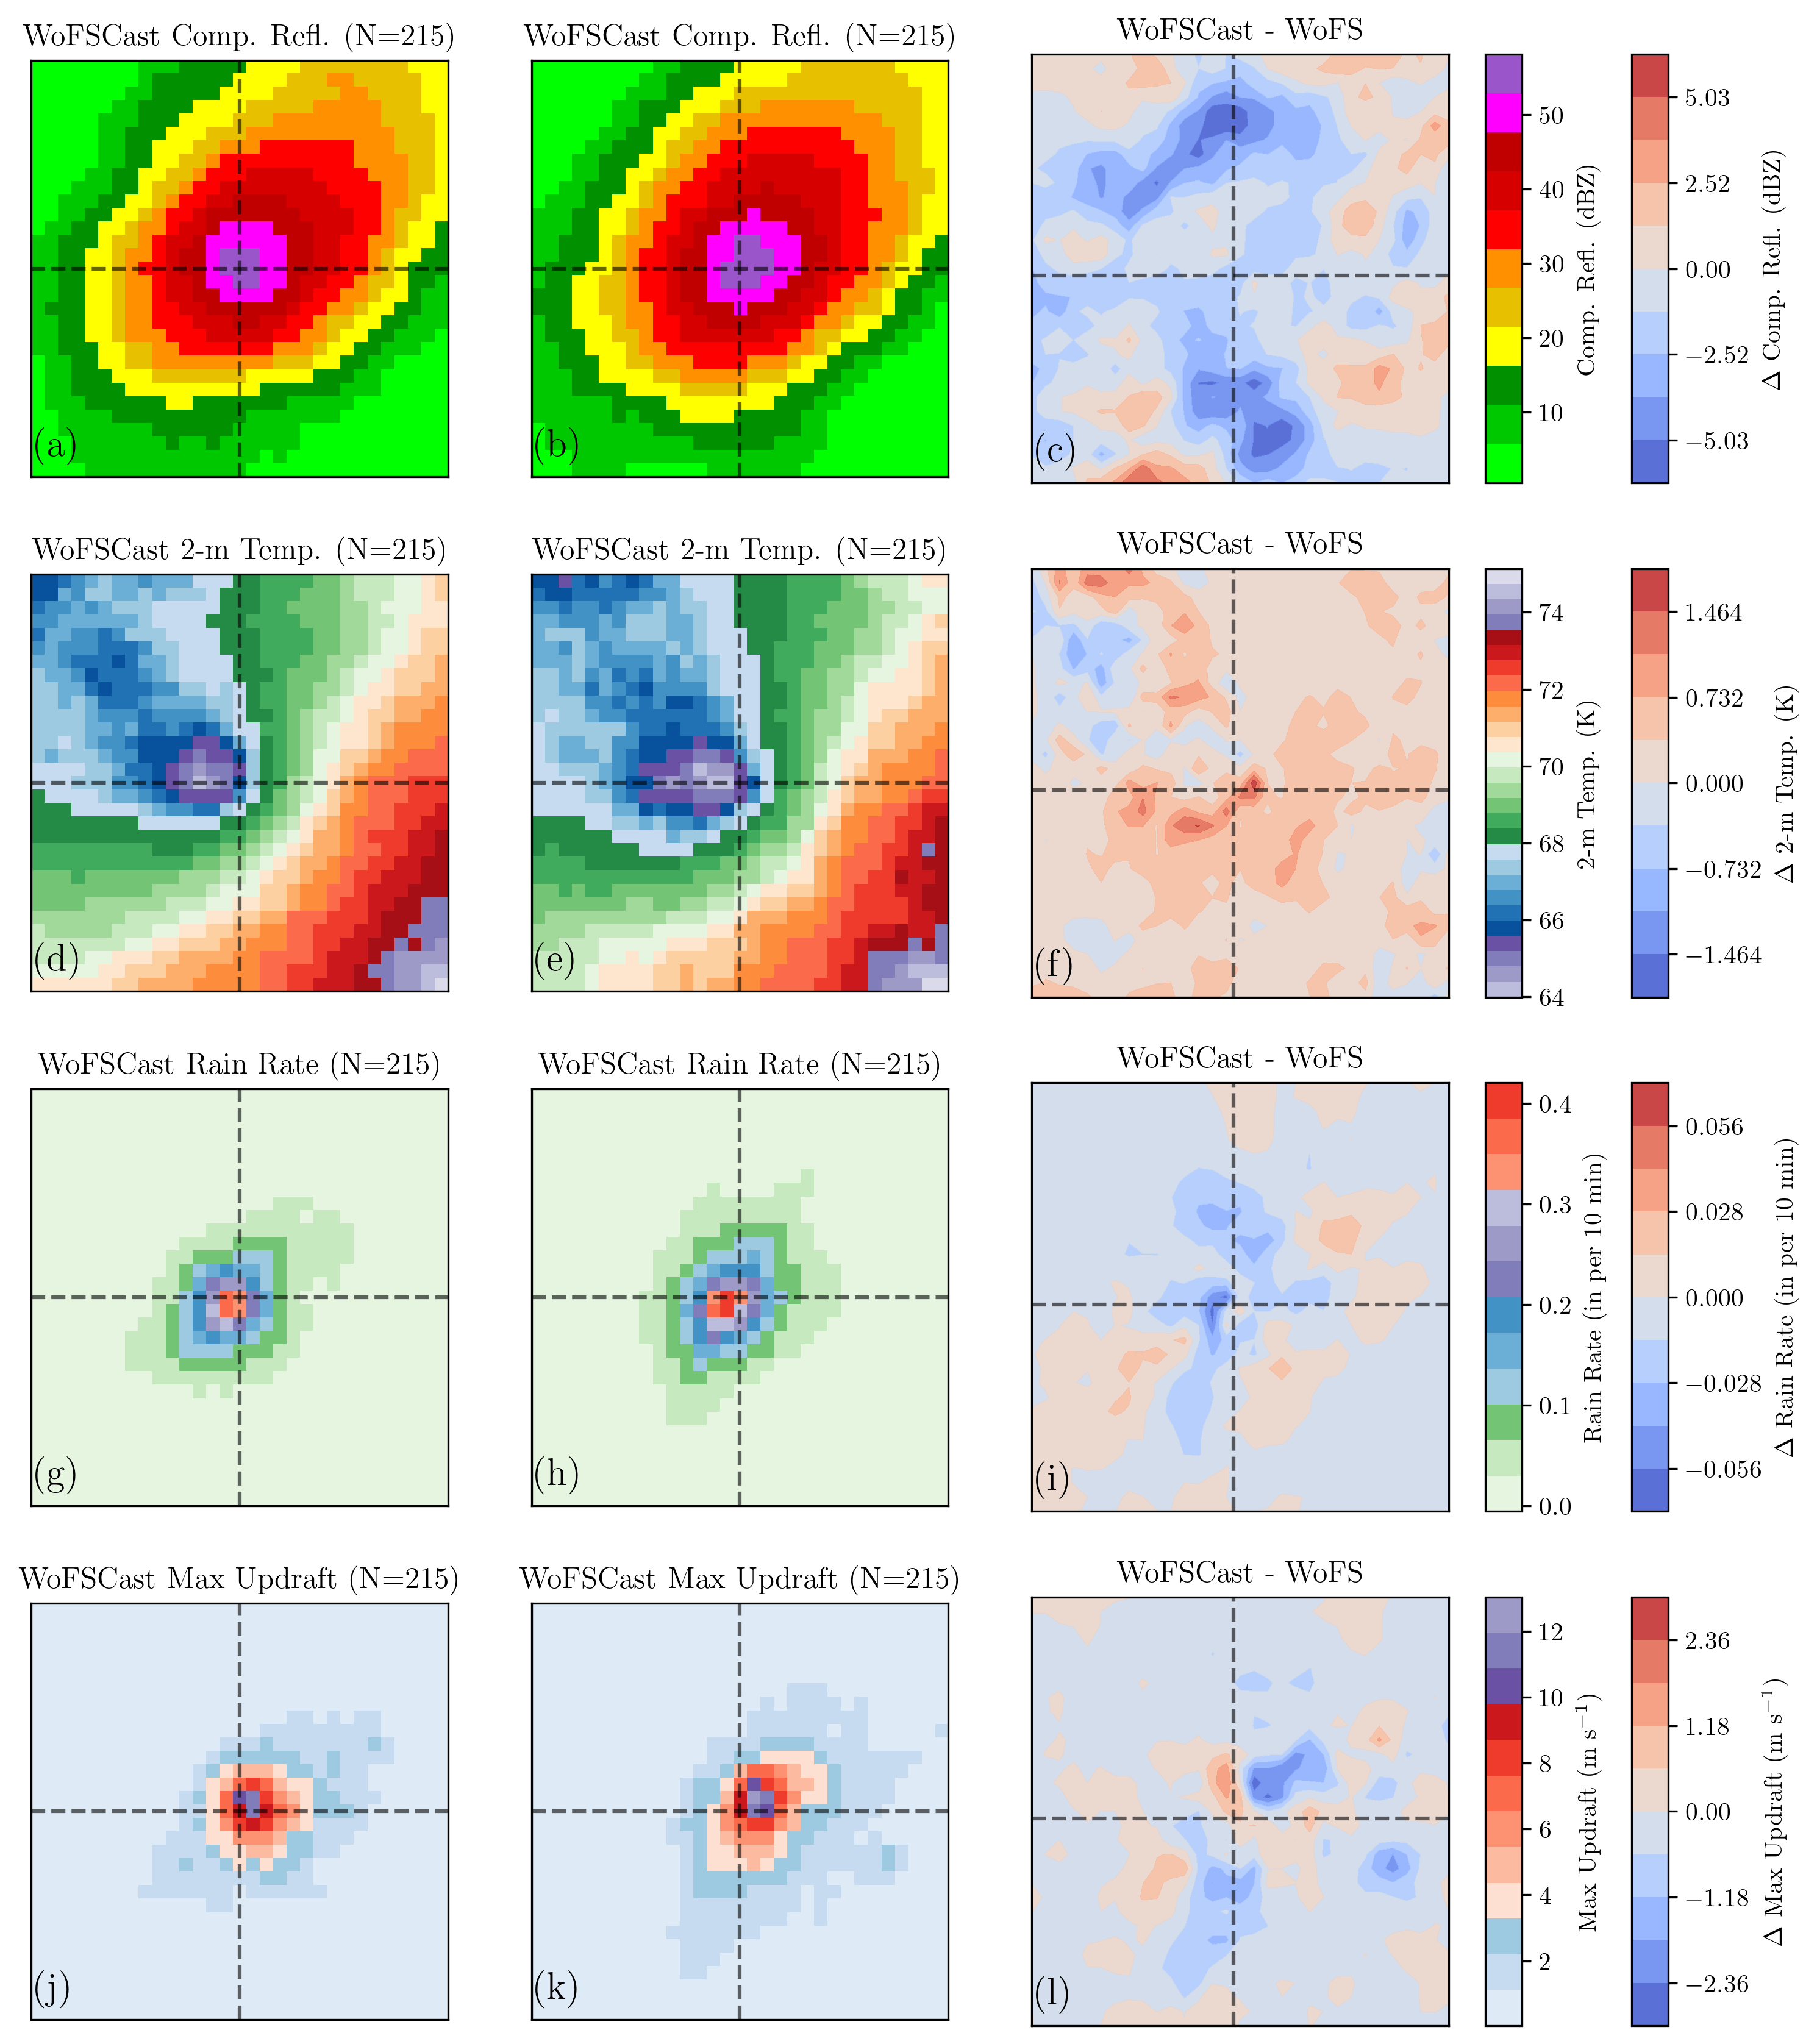

In [16]:
import matplotlib.pyplot as plt
import numpy as np  # Assuming you need numpy for calculating the difference

labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate',
               'T2' : '2-m Temp.',
               'WMAX' : 'Max Updraft'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'in per 10 min',
               'T2' : 'K',
               'WMAX' : 'm s$^{-1}$'
              }


def get_colormap_and_levels(var):
        if var == 'COMPOSITE_REFL_10CM':
            cmap = WoFSColors.nws_dz_cmap
            levels = WoFSLevels.dz_levels_nws
        elif var == 'RAIN_AMOUNT':
            cmap = WoFSColors.rain_cmap
            levels = WoFSLevels.rain_rate_levels
        elif var == 'UP_HELI_MAX':
            cmap = WoFSColors.wz_cmap_extend
            levels = WoFSLevels.uh_2to5_levels_3000m
        elif var == 'T2':
            cmap = WoFSColors.temp_cmap
            levels = np.arange(40., 90., 2.5)
        elif var == 'QVAPOR': 
            cmap = WoFSColors.temp_cmap
        elif var in ['W', 'WMAX']: 
            cmap = WoFSColors.wz_cmap_extend
            levels = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]#, 25]#, 30, 35, 40]
        else:
            cmap = WoFSColors.wz_cmap_extend
        
        return cmap, levels

fig, axes = plt.subplots(nrows=len(field_list), ncols=3, figsize=(10, 14), dpi=300)

for i, (axs, field_name) in enumerate(zip(axes, field_list)):
    cmap, levels = get_colormap_and_levels(field_name)
    
    vmin = np.min([true_PMMs[field_name], pred_PMMs[field_name]])
    vmax = np.max([true_PMMs[field_name], pred_PMMs[field_name]])
    
    # Plot the first column (True PMM)
    im1 = axs[0].imshow(pred_PMMs[field_name], origin='lower', aspect='equal', cmap=cmap,
                        vmin=vmin, vmax=vmax,
                          #levels=levels
                         )
    axs[0].set_title('WoFSCast %s (N=%d)' % (labels_dict[field_name], N), fontweight='bold')
    
    # Plot the second column (Predicted PMM)
    im2 = axs[1].imshow(true_PMMs[field_name], origin='lower', aspect='equal', cmap=cmap, 
                          #levels=levels,
                          vmin=vmin, vmax=vmax,
                         )
    axs[1].set_title('WoFSCast %s (N=%d)' % (labels_dict[field_name], N), fontweight='bold')
    
    # Calculate the difference between the two fields
    #pred = np.where(pred_PMMs[field_name] < np.min(levels), 0, pred_PMMs[field_name])
    #true = np.where(true_PMMs[field_name] < np.min(levels), 0, true_PMMs[field_name])
    
    difference = pred_PMMs[field_name] - true_PMMs[field_name] 
    
    # Mask values less than or equal to 0.0001
    #difference = np.ma.masked_where(np.abs(difference) <= 0.0001, difference)
    
    # Determine vmin and vmax based on the absolute max of the difference

    vmax = np.round(np.max(np.abs(difference)) * 1.05, 2)
    vmin = -vmax
    
    # Plot the third column (Difference)
    im3 = axs[2].contourf(difference, origin='lower', aspect='equal', cmap='coolwarm', alpha=0.9, 
                          levels=np.linspace(vmin, vmax, 11))
    axs[2].set_title('WoFSCast - WoFS', fontweight='bold')

    # Create a colorbar axis on the right side of the third panel
    cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.02, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_ylabel(f'{labels_dict[field_name]} ({units_dict[field_name]})')
    
    
    # Create a colorbar axis on the right side of the third panel
    cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.1, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
    cbar = fig.colorbar(im3, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_ylabel(f'$\Delta$ {labels_dict[field_name]} ({units_dict[field_name]})')
    
    
    
    
for i, ax in enumerate(axes.flat):
    #ax.grid(ls='dashed', alpha=0.6)
    # Turn off tick marks for both axes
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.annotate(f'({lowercase_letters[i]})', xy=(0.01, 0.05), xycoords='axes fraction', fontsize=15)
    ax.axvline(x=15, color='k', ls='dashed', alpha=0.6)
    ax.axhline(y=15, color='k', ls='dashed', alpha=0.6)

#plt.tight_layout()
#plt.show()


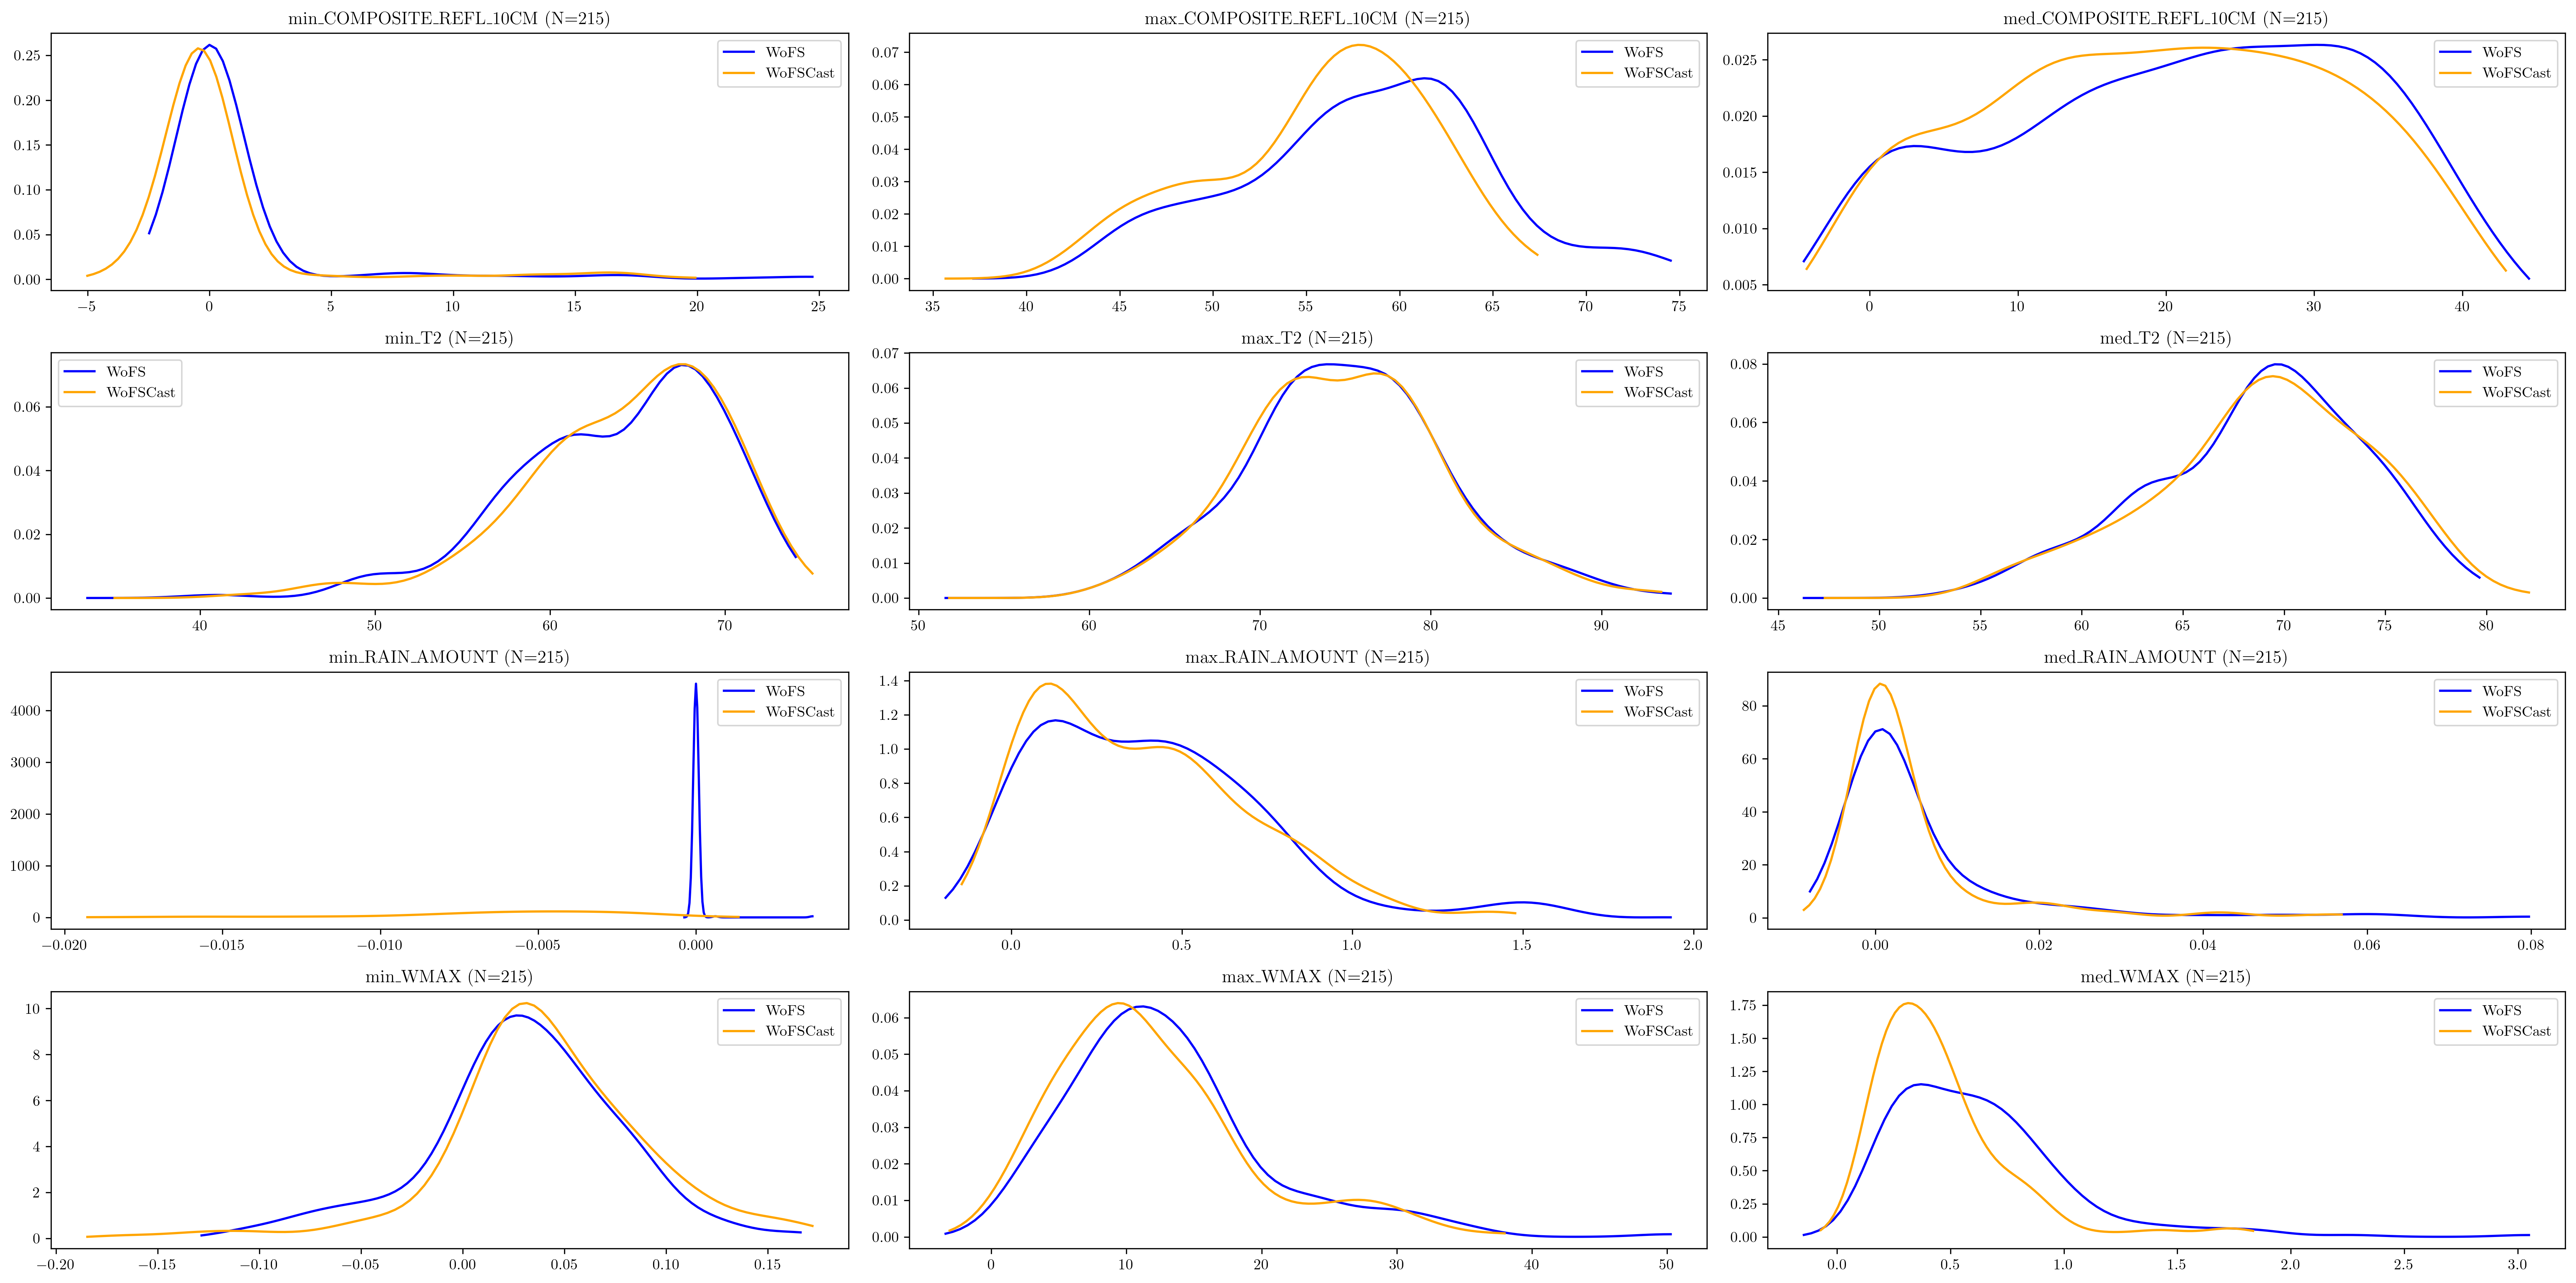

In [64]:
fig, axes = plt.subplots(len(field_list), len(stat_funcs), figsize=(24, 12), dpi=300)
for ax, func_name  in zip(axes.flatten(), pred_field_stats.keys()):
    data=true_field_stats[func_name]
    xs = np.linspace(data.min()-data.max()/10, data.max(), 100)
    vals = stats.gaussian_kde(data)(xs)
    ax.plot(xs, vals, label='WoFS', color='blue')
    data=pred_field_stats[func_name]
    xs = np.linspace(data.min()-data.max()/10, data.max(), 100)
    vals = stats.gaussian_kde(data)(xs)
    ax.plot(xs, vals, label='WoFSCast', color='orange')
    ax.set_title('%s (N=%d)' % (func_name, N))
    ax.legend()
plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_KDE_t=%d_N=%d.jpg' % (t, N_SAMPLES))
#plt.savefig(figname, bbox_inches='tight')

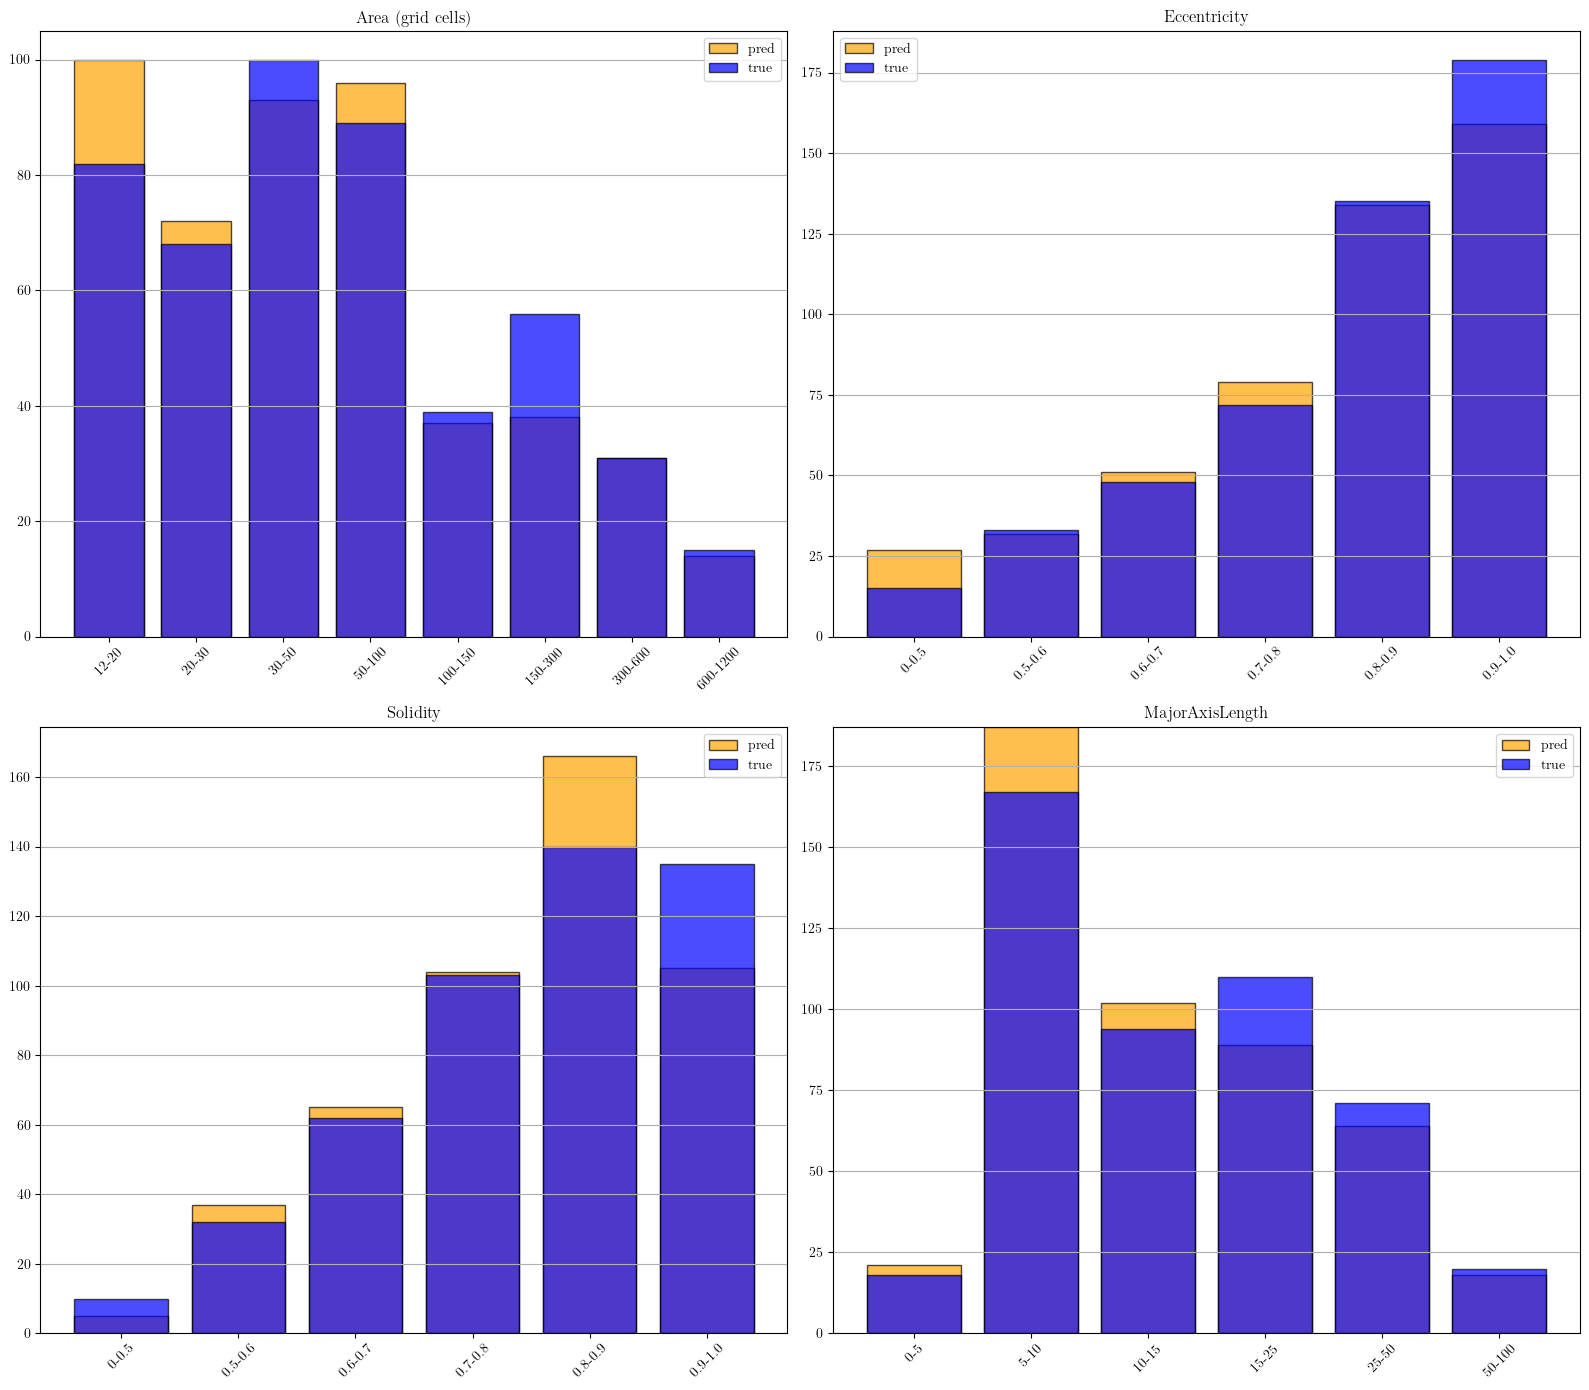

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

bin_edges_dict = {'Area':[12, 20, 30, 50, 100, 150, 300, 600, 1200],
                  'Eccentricity': [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'Solidity': [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'MajorAxisLength': [0, 5, 10, 15, 25, 50, 100],
            }

metrics = ['Area', 'Eccentricity', 'Solidity', 'MajorAxisLength']

for metric, ax in zip(metrics, axs.flatten()): 

    all_pred = all_matched_pred_object_props_dict[metric]#[prop[metric] for prop in all_matched_pred_object_props]
    all_true = all_matched_true_object_props_dict[metric]#[prop[metric] for prop in all_matched_true_object_props]

    bin_edges = bin_edges_dict[metric]
    bin_centers = range(len(bin_edges)-1)

    pred_hist, edges = np.histogram(all_pred, bins=bin_edges)
    true_hist, edges = np.histogram(all_true, bins=bin_edges)
    ymax = max(pred_hist.max(), true_hist.max())

    im1 = ax.bar(bin_centers, pred_hist, edgecolor='black', color='orange', alpha=0.7, label='pred')
    im2 = ax.bar(bin_centers, true_hist, edgecolor='black', color='blue', alpha=0.7, label='true')
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f'{left}-{right}' for left, right in zip(bin_edges[:-1], bin_edges[1:])], rotation=45)
    plt.ylim(0, ymax)
    ax.grid(True, axis='y')
    ax.legend(labels=['pred', 'true'])
    if metric=='Area':
        ax.set_title('Area (grid cells)')
    else:
        ax.set_title(metric)

plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_object_props.jpg')
#plt.savefig(figname, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'min'

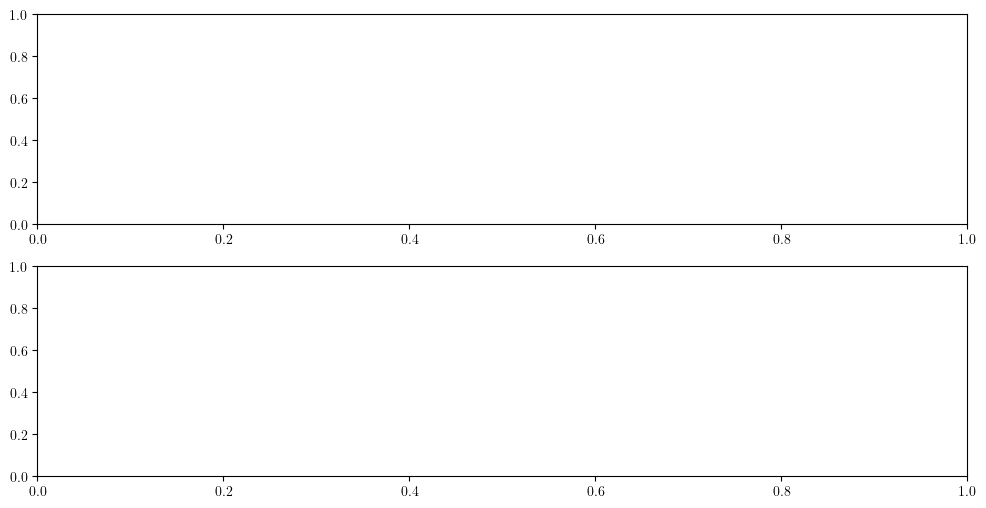

In [66]:
metrics_list = [ ['Area', 'Eccentricity'], ['Area', 'Intensity_Max'] ]

fig, axes = plt.subplots(len(metrics_list), 1, figsize=(6*len(metrics_list), 6))

for ax, metrics  in zip(axes, metrics_list):
    
    pred1 = all_matched_pred_object_props_dict[metrics[0]]
    true1 = all_matched_true_object_props_dict[metrics[0]]
    pred2 = all_matched_pred_object_props_dict[metrics[1]]
    true2 = all_matched_true_object_props_dict[metrics[1]]
    
    xmin = min(pred1.min(), true1.min()); xmax = max(pred1.max(), true1.max())
    ymin = min(pred2.min(), true2.min()); xmax = max(pred2.max(), true2.max())
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    values = np.vstack([pred1, true1])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, xx.shape)
    levels = []
    thresh = [50., 75., 90., 95., 97.5, 99., 99.9]
    for i in range(0, len(thresh)):
        levels.append(np.percentile(Z.ravel(), thresh[i]))
    ax1 = plt.contourf(xx, yy, Z, levels=levels, extend='max', cmap = 'Reds')
    
    values = np.vstack([pred2, true2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, xx.shape)
    levels = []
    thresh = [50., 75., 90., 95., 97.5, 99., 99.9]
    for i in range(0, len(thresh)):
        levels.append(np.percentile(Z.ravel(), thresh[i]))
    ax2 = plt.contourf(xx, yy, Z, levels=levels, extend='max', cmap = 'Reds')
    
plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_OBJECT_KDE_t=%d_N=%d.jpg' % (t, N_SAMPLES))
#plt.savefig(figname, bbox_inches='tight')

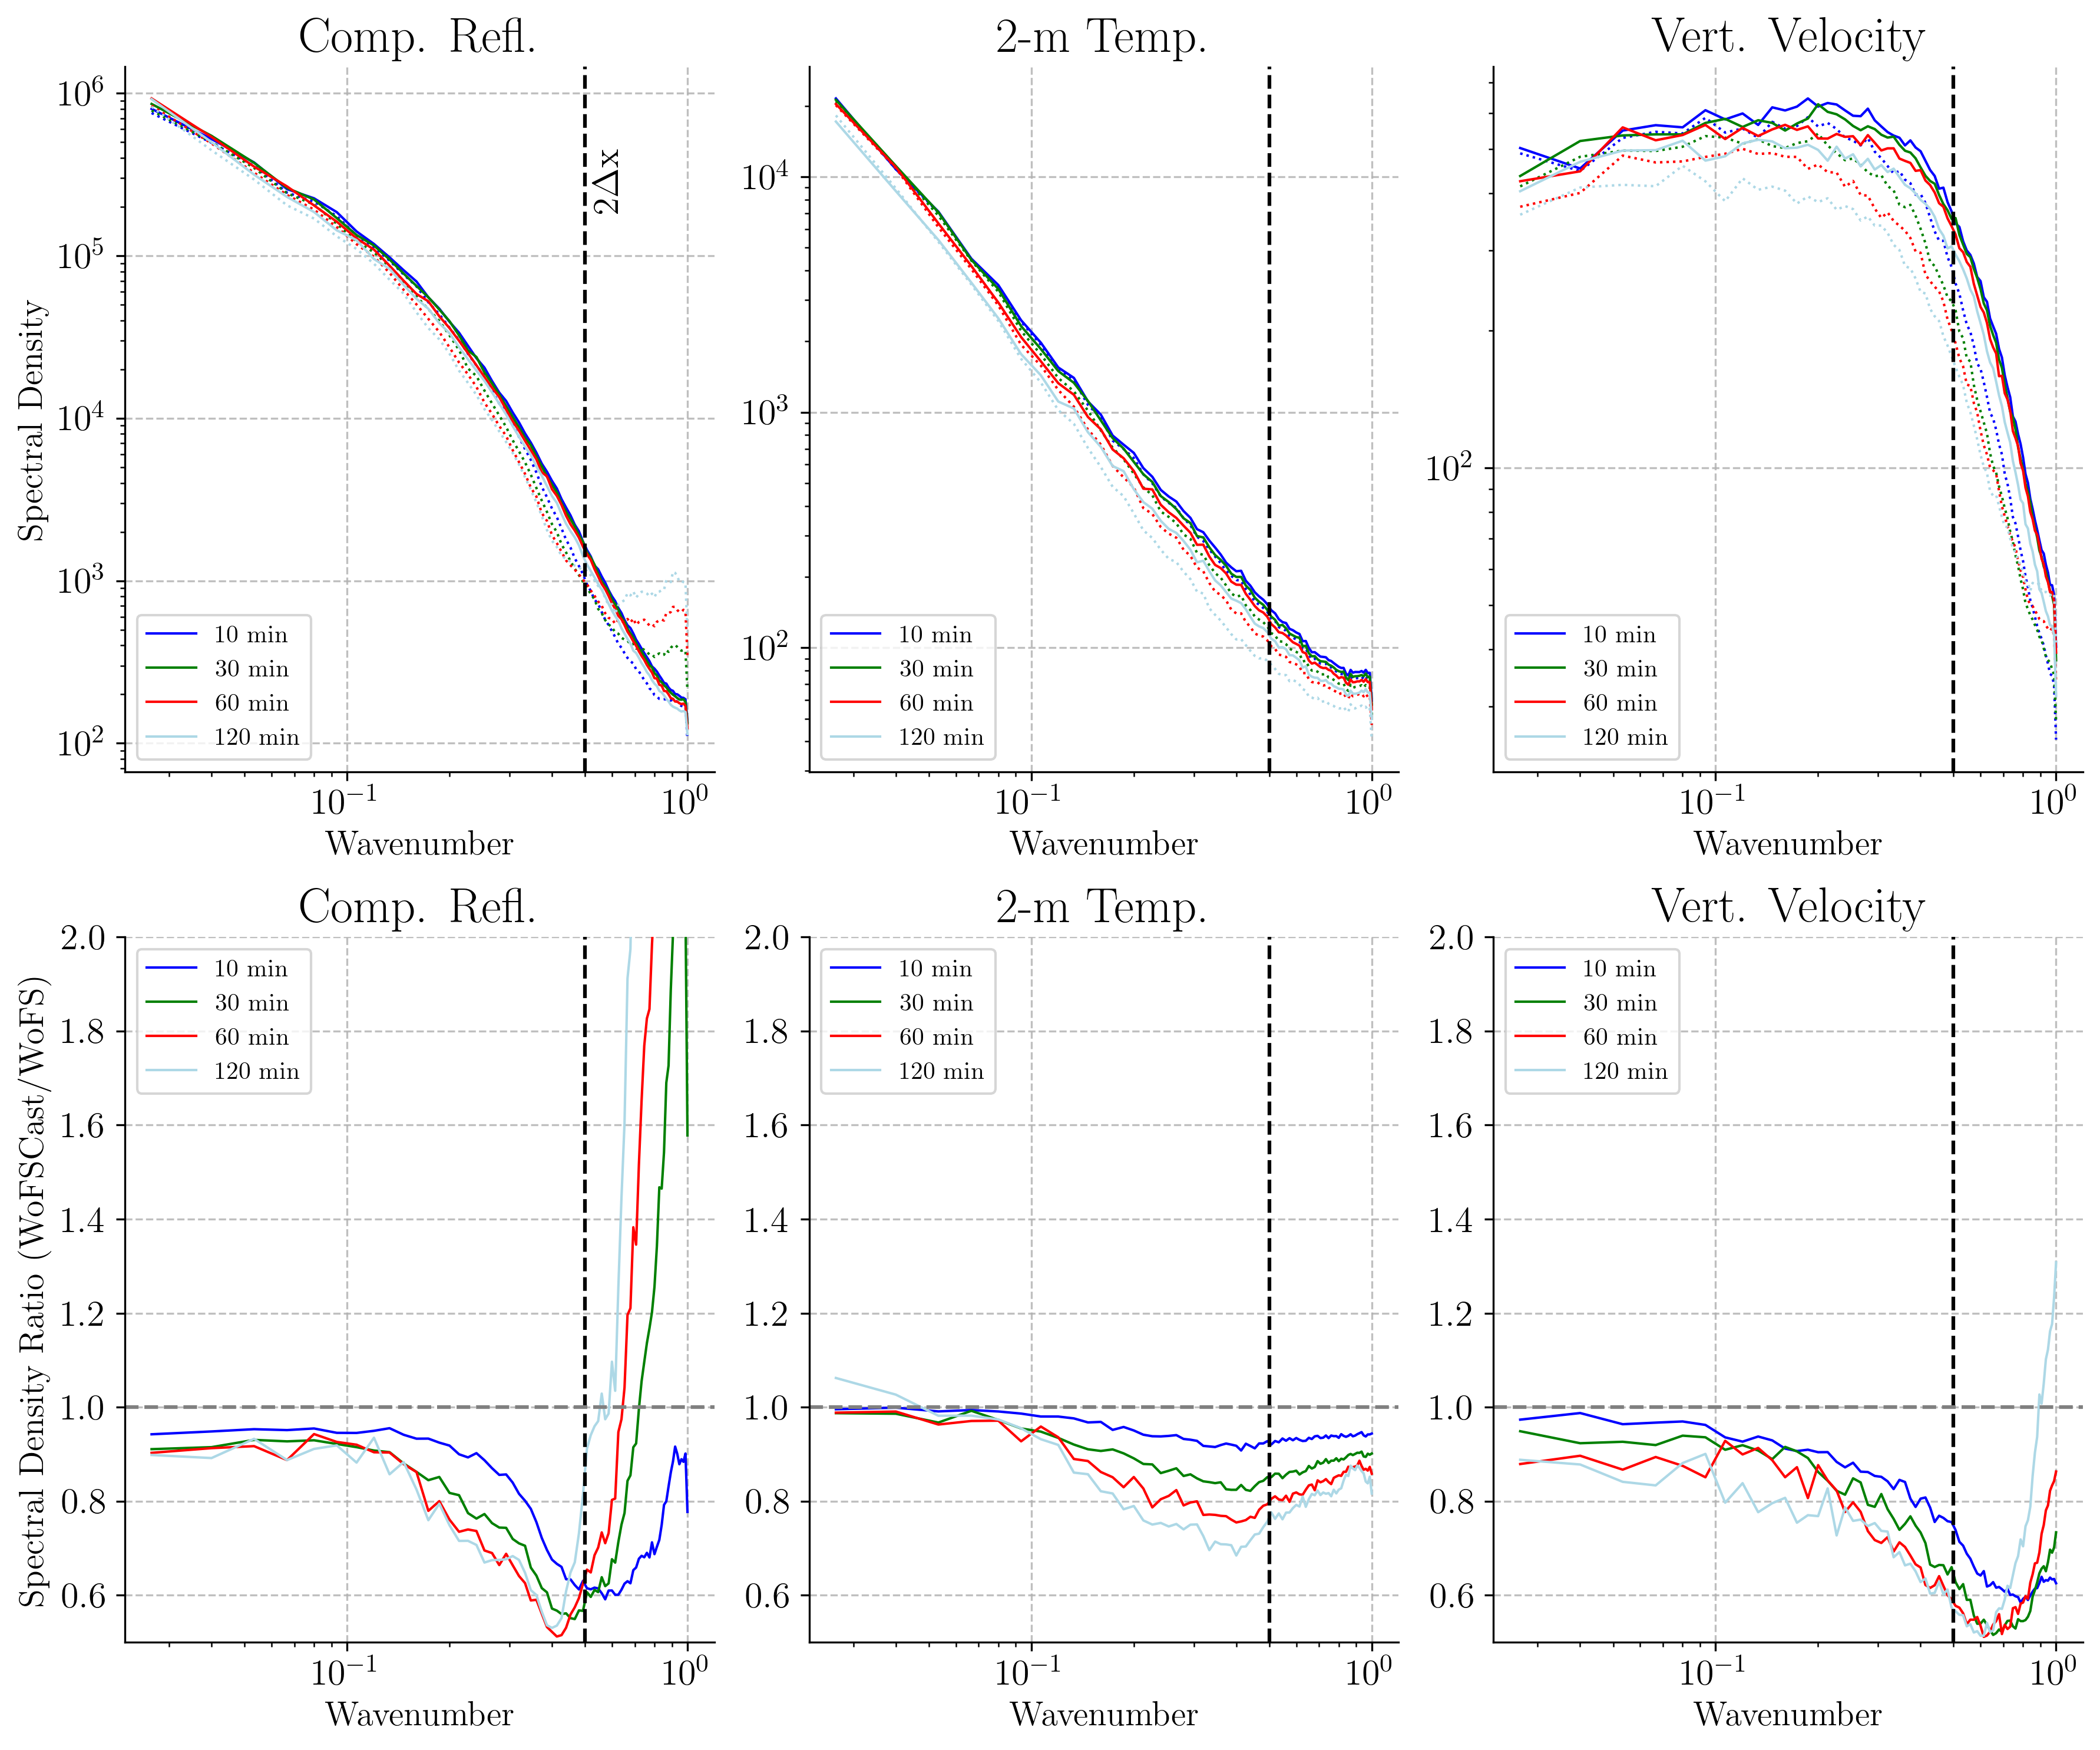

In [97]:
times = (np.arange(n_times)+1)*10 # in minutes 
fig, axes = plt.subplots(figsize=(12,10), dpi=300, ncols=3, nrows=2, sharey=False)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']

for i, (var, ax,) in enumerate(zip(spectra_vars, axes.flat[:3])): 
    n=0
    for t, time in enumerate(times):
        if time in [10, 30, 60, 120]:
            ax.loglog(waven[1:], pred_spectra_dict[var][t][1:], c=colors[n], lw=1, ls=':') 
            ax.loglog(waven[1:], tar_spectra_dict[var][t][1:], c=colors[n], lw=1, label=f'{time} min')
            n += 1
    ax.legend(loc='lower left')
    
    ylabel = r"Spectral Density" if i==0 else ""
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(r"Wavenumber", fontsize=14)
    ax.set_title(display_name_mapper.get(var,var), fontsize=20)
    
 
    #ax.set_xlim(2/waven.shape[0], 1.0)
    ax.grid(ls='dashed', alpha=0.8)
    ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5) 
    ax.annotate('2$\Delta$x', xy=(0.525, 2e5), rotation=90, fontsize=15)
    
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Increase tick font size
    ax.tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels

for i, (var, ax,) in enumerate(zip(spectra_vars, axes.flat[3:])): 
    n=0
    for t, time in enumerate(times):
        if time in [10, 30, 60, 120]:
            ratio = pred_spectra_dict[var][t][1:] / tar_spectra_dict[var][t][1:]
            
            ax.plot(waven[1:], ratio, c=colors[n], lw=1, label=f'{time} min') 
            #ax.loglog(waven[1:], tar_spectra_dict[var][t][1:], c=colors[n], lw=1, label=f'{time} min')
            n += 1
    ax.legend(loc='upper left')
    
    ylabel = r"Spectral Density Ratio (WoFSCast/WoFS)" if i==0 else ""
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(r"Wavenumber", fontsize=14)
    ax.set_title(display_name_mapper.get(var,var), fontsize=20)
    
    # Set x-axis to logarithmic scale
    ax.set_xscale('log')
 
    #ax.set_xlim(2/waven.shape[0], 1.0)
    ax.grid(ls='dashed', alpha=0.8)
    ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5) 
    ax.axhline(y=1.0, linestyle='--', color='gray', lw=1.5) 
    ax.annotate('2$\Delta$x', xy=(0.525, 2e5), rotation=90, fontsize=15)
    
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Increase tick font size
    ax.tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels
    ax.set_ylim([0.5, 2.0])
    
    
plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_SPECTRA.jpg')
#plt.savefig(figname, bbox_inches='tight')

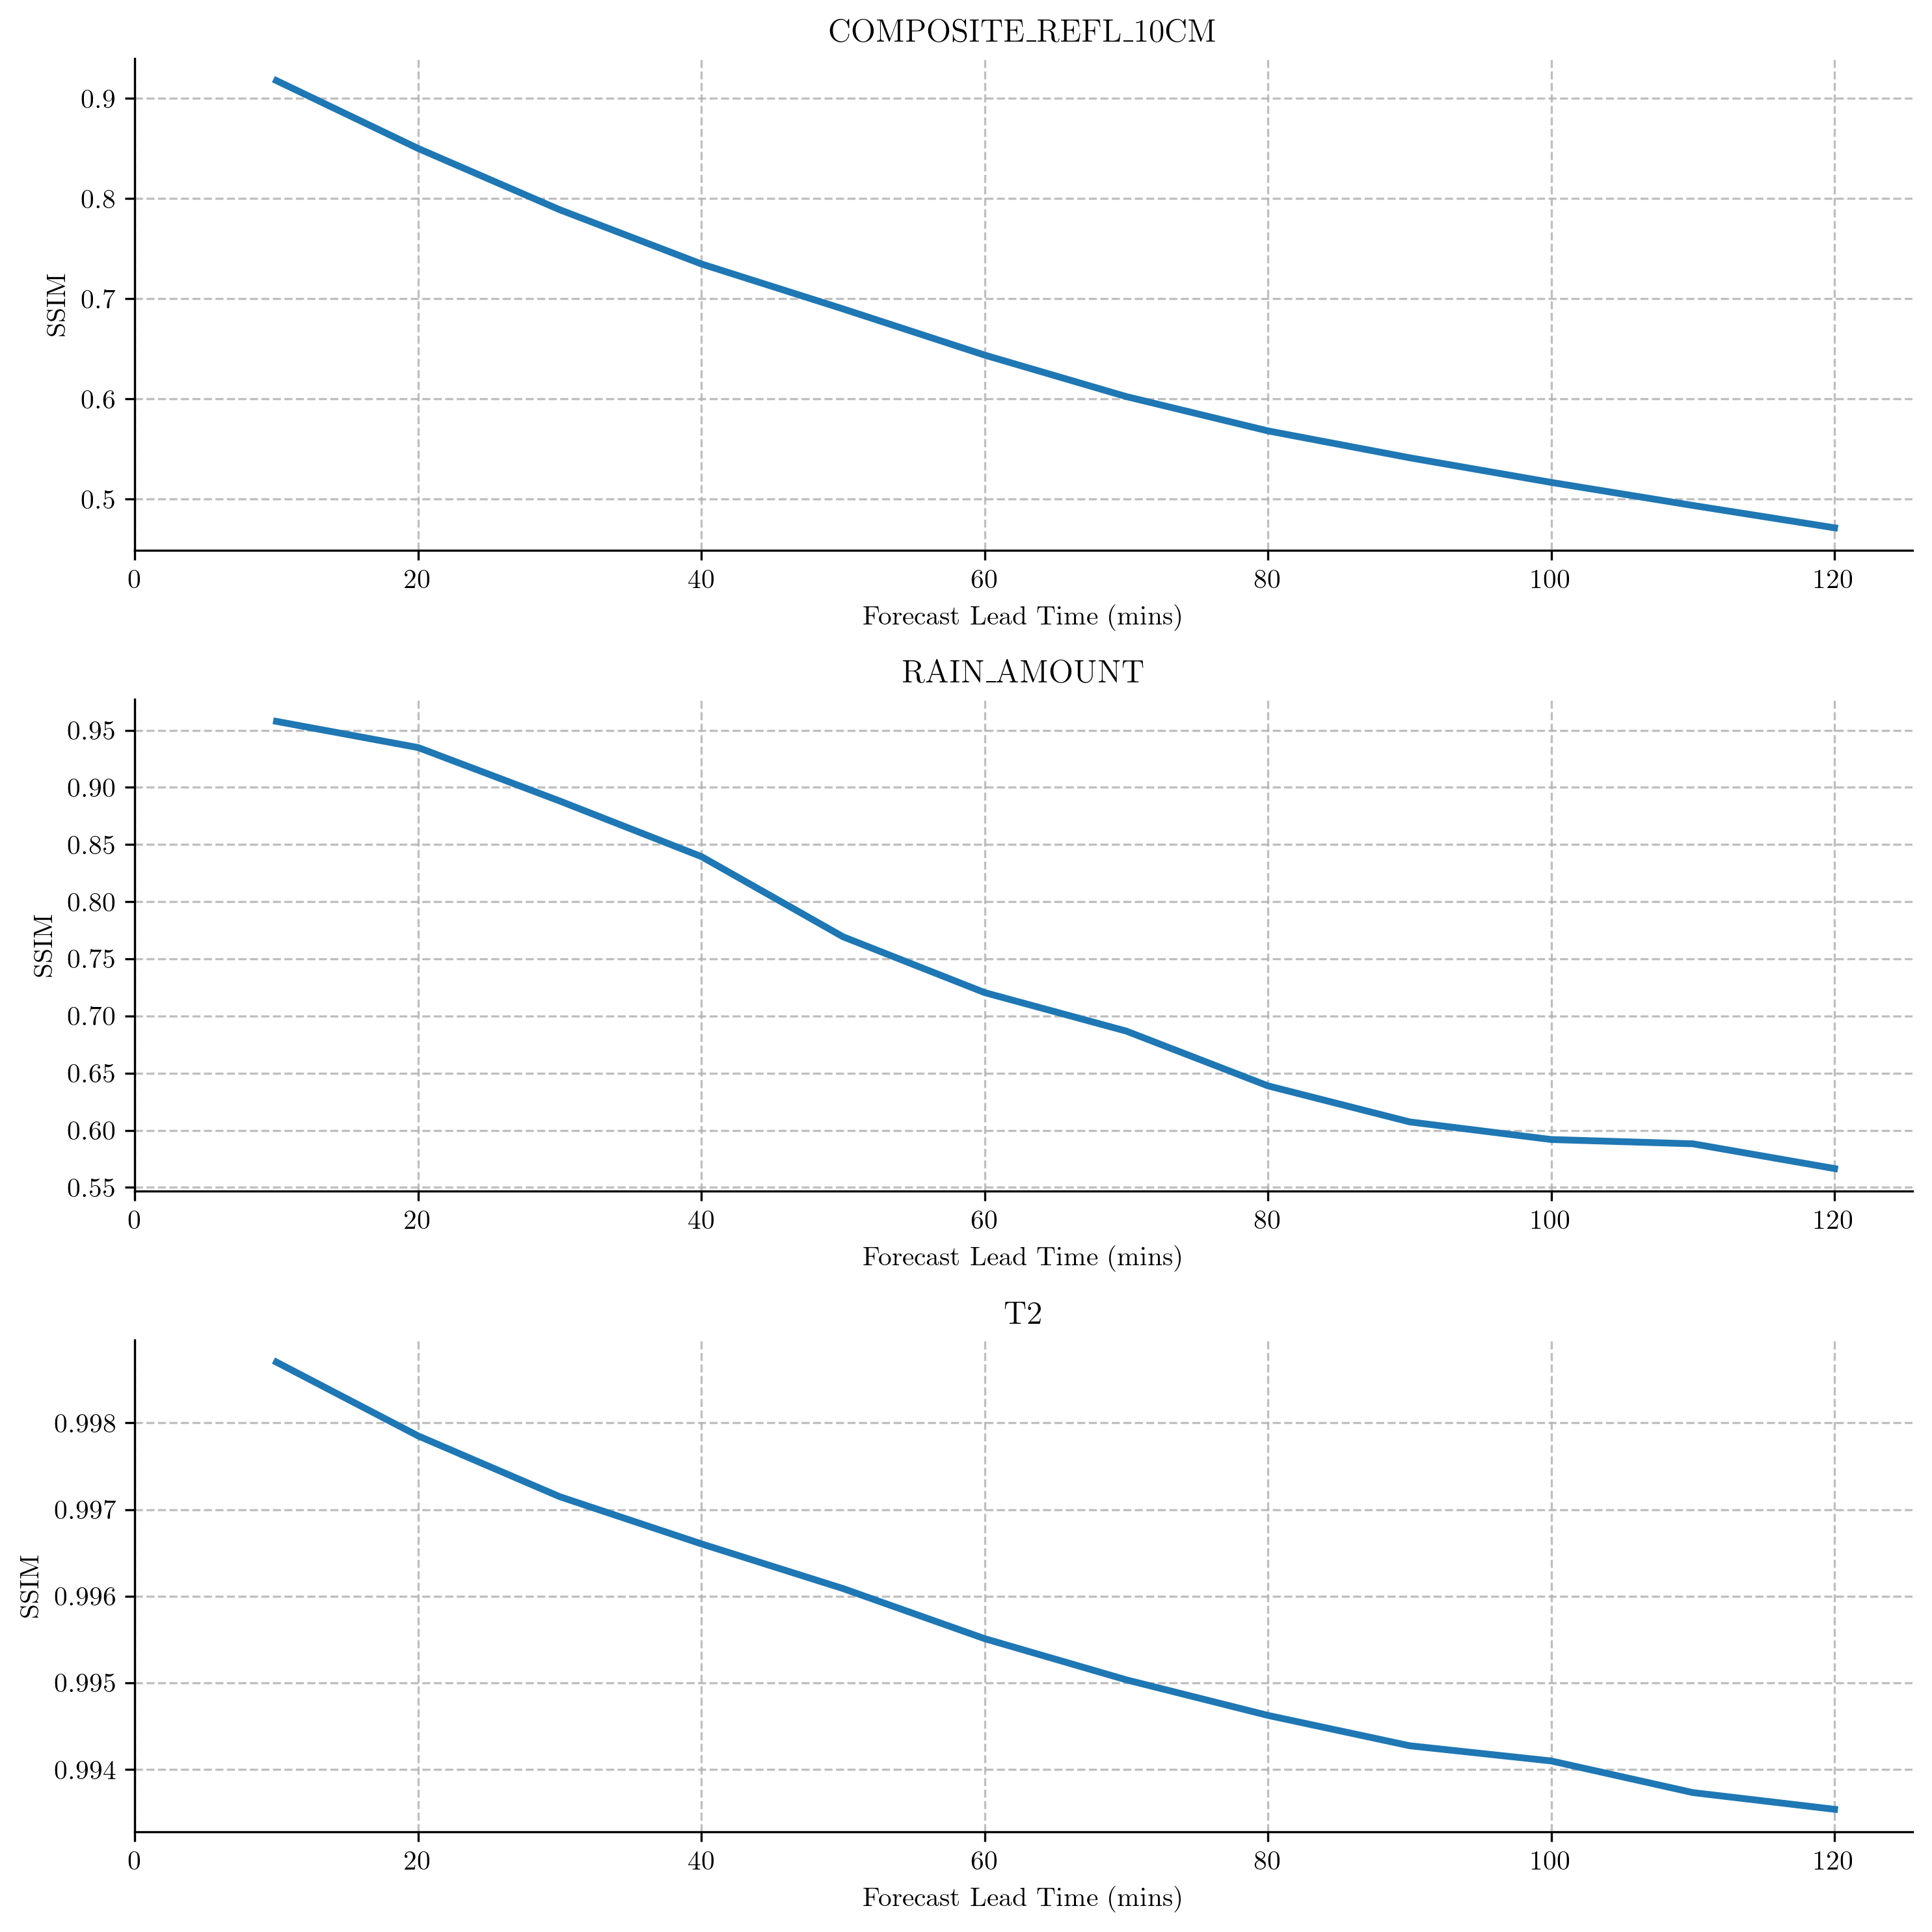

In [99]:
times = (np.arange(n_times)+1)*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=1, nrows=len(SSIM_vars), sharex=False)

for var, ax in zip(SSIM_vars, axes.flat): 
    ax.plot(times, SSIM_dict[var], lw=2.5) 

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
           ylabel= 'SSIM', 
           title = var,
        )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    
plt.tight_layout()
#figname = MODEL_PATH.replace('.npz', '_SSIM.jpg')
#plt.savefig(figname, bbox_inches='tight')

In [ ]:
times = (np.arange(n_times)+1)*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=1, nrows=len(TV_vars), sharex=False)

for var, ax in zip(TV_vars, axes.flat): 
    ax.plot(times, TV_dict[var], lw=2.5) 

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
           ylabel= 'TV ratio', 
           title = var,
        )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    
plt.tight_layout()
figname = MODEL_PATH.replace('.npz', '_TV.jpg')
plt.savefig(figname, bbox_inches='tight')